In [318]:
# Tensorflow
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Lambda, Add, Input, Dense, Activation, Conv3D, MaxPooling3D, AveragePooling3D,concatenate, BatchNormalization, Dropout, Flatten, Reshape, Conv3DTranspose, UpSampling3D
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Model, load_model
#from keras.utils import to_categorical
from tensorflow.keras.initializers import glorot_uniform, he_uniform
from tensorflow.keras.optimizers import Adam, SGD, Adagrad, Adadelta
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.python.keras.callbacks import TensorBoard,ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
import tensorflow.keras.backend as K
K.set_image_data_format('channels_last')
from tensorflow.keras.utils import normalize
from tensorflow.keras.activations import relu
tf.keras.backend.clear_session()

import numpy as np
import math
from itertools import product
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from mpl_toolkits.mplot3d import Axes3D
from contextlib import redirect_stdout
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
%matplotlib inline
import seaborn as sns
from contextlib import redirect_stdout
import time
import seaborn as sns
import scipy
from scipy import io, stats
from scipy.stats import mannwhitneyu
import pymc3 as pm
import matplotlib
from astropy.stats import jackknife_resampling, jackknife_stats, binom_conf_interval
import xgboost as xgb

from sklearn import svm
from sklearn.metrics import auc, RocCurveDisplay, roc_curve, f1_score, confusion_matrix, classification_report
# from scikitplot.metrics import plot_roc_curve
from sklearn.preprocessing import LabelEncoder
class_labels = LabelEncoder()
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix
from sklearn import decomposition
from sklearn.manifold import TSNE
from sklearn.feature_selection import VarianceThreshold, RFE, SelectFromModel, SelectKBest, f_classif, chi2, mutual_info_classif
from sklearn import linear_model
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn import preprocessing
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
   
def relu_out(x):
    return tf.minimum(relu(x), 1)

seed_value= 0
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)
np.random.seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)

tf.compat.v1.disable_eager_execution()
init_op = tf.compat.v1.global_variables_initializer()
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.allow_soft_placement = True
config.gpu_options.per_process_gpu_memory_fraction = 0.4
sess = tf.compat.v1.Session(config=config)
run_opts = tf.compat.v1.RunOptions(report_tensor_allocations_upon_oom = True)
sess.run(init_op)

In [182]:
# [Library Init] Above & [Read Data for Lesion Normalization] Below

In [451]:
# # ---All features (63 here), to be used with PCA/tSNE---

# X = pd.read_csv("dwi_data/22_S_Les_All_Fts_Viz.csv")
X = pd.read_csv("dwi_data/22_S_Les_MnMSk_All_Fts_Viz.csv")

Y = pd.read_csv("dwi_data/22_S_Labels.csv")

# X = np.asarray(X)
# Y = np.asarray(Y)

# print('\n',X.head(1))
# print('\n',Y.head(1))

# X = X.reshape((22,8,8,1))
# X = pd.read_csv("dwi_data/22_S_Les_All_Fts_Viz_Ctrl.csv")

In [449]:
# # ---All features (63 here), to be used with PCA/tSNE/Other choice of Feature Selection---

X = pd.read_csv("dwi_data/22_S_NL_All_Fts_Viz.csv")
# X = pd.read_csv("dwi_data/22_S_NL_MnMSk_All_Fts_Viz.csv")

Y = pd.read_csv("dwi_data/22_S_Labels.csv")

# X = np.asarray(X)
# Y = np.asarray(Y)
# print('\n',X.head(1))
# print('\n',Y.head(1))

In [182]:
# [Read NL Data (Aug 12)] Above 

In [50]:
def pgm(input_feat=5, dr=False, dr_rate=0, l_1=0, l_2=0, act='relu', act_f='sigmoid', init='glorot_uniform'):
        
    ip = (input_feat,)
    
    inputs = Input(shape=ip, name='input')
    
    # Phase 1 'sigmoid' relu_out
    x = Dense(units=2, activation=act, kernel_regularizer=l1_l2(l1=l_1, l2=l_2), name='fc_1')(inputs)
#     x = Dense(units=4, activation=act, kernel_regularizer=l1_l2(l1=l_1, l2=l_2), name='fc_1')(inputs)
    if dr:
        x = Dropout(dr_rate)(x) 
 
#     x = Dense(units=2, activation=act, kernel_regularizer=l1_l2(l1=l_1, l2=l_2), name='fc_2')(x)
#     if dr:
#         x = Dropout(dr_rate)(x) 
 
    y = Dense(units=1, activation=act_f, name='fc_4')(x)
    
    return Model(inputs=inputs, outputs=y)

In [160]:
# [MLP] Above & [Training and Evaluation] Below

In [122]:
seed_value= 10
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)

# all_preds = []
subj = 22
feats_list = [63] # no. of features selected
fold_list = [6]
# cv_rep = [1,2,3,4,5]
cv_rep = [63]

data_type  = np.float32
acc_max = []
auc_max = []

for feats in cv_rep:
    for fold_no in fold_list:

        acc_scores = []        
        folds = StratifiedKFold(n_splits=fold_no, shuffle=True, 
                                    random_state=0).split(X, Y)
#                                     random_state=feats).split(X, Y)

        for k, (train_idx, test_idx) in enumerate(folds):

            X_train_CV = X.iloc[train_idx,:]  
            Y_train_CV = Y.iloc[train_idx]   
            Y_train_CV = np.ravel(Y_train_CV)
        #     Y_train_CV = Y_train_CV[:,np.newaxis]
            X_test_CV = X.iloc[test_idx,:]   
            Y_test_CV = Y.iloc[test_idx]  
            Y_test_CV = np.ravel(Y_test_CV)
            Y_test_CV = np.array(Y_test_CV)            
            
#             sel_mutual = SelectKBest(chi2, k=feats)    
#             X_train_CV = sel_mutual.fit_transform(X_train_CV, Y_train_CV)
#             X_test_CV = sel_mutual.transform(X_test_CV)
        
            run_str = str(feats)+'_feats_MLP_fold_'+str(k+1)

            PGM = None
            PGM = pgm(input_feat=feats)

#             PGM.compile(optimizer='Adam', loss=losses.binary_crossentropy, metrics=['accuracy'])
            PGM.compile(optimizer=Adadelta(lr=1.0), loss=losses.mean_squared_error, metrics=['mse'])
            PGM.summary()
            es = EarlyStopping(monitor='loss', mode='auto', verbose=1, patience=10, min_delta=5e-5) 
            lred = ReduceLROnPlateau(monitor='loss', factor=0.7, min_delta = 1e-4,
                                     mode='auto', patience=5, verbose=1, min_lr=1e-5, cooldown=0)
            mc = ModelCheckpoint('weights//'+run_str+'.h5', monitor='loss', mode='auto',
                                 save_best_only=True, verbose=1)

            history = PGM.fit(X_train_CV, Y_train_CV, callbacks=[es,lred,mc], epochs=100)

            PGM.load_weights('weights//'+run_str+'.h5', by_name=True)
            predictions = PGM.predict(X_test_CV)
#             all_preds.append(predictions)

            pred_label = []
            for i in predictions:
                if i<0.5:
                    pred_label.append(0)
                else:
                    pred_label.append(1)

            acc = 0.   
            for i,j in zip(Y_test_CV,pred_label):      
                if i==j:
                    acc+=1.

            acc /= (test_idx.size)  
            acc_scores.append(acc)

        print(np.mean(acc_scores))
        print(np.std(acc_scores))

#         acc_scores_list = []
#         acc_scores_list = np.array(acc_scores)
#         #     resamples = jackknife_resampling(acc_scores_list)
#         test_statistic = lambda x: (np.mean(x), np.var(x))
#         estimate, bias, stderr, conf_interval = jackknife_stats(acc_scores_list, test_statistic, 0.95)    
#         print(estimate)
#         print(acc_scores_list)

Model: "model_74"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 63)]              0         
_________________________________________________________________
fc_1 (Dense)                 (None, 2)                 128       
_________________________________________________________________
fc_4 (Dense)                 (None, 1)                 3         
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________
Train on 18 samples
Epoch 1/100

Epoch 00001: loss improved from inf to 0.26584, saving model to weights//63_feats_MLP_fold_1.h5
18/18 [==============================] - 0s 3ms/sample - loss: 0.2658 - mse: 0.2658
Epoch 2/100

Epoch 00002: loss improved from 0.26584 to 0.26417, saving model to weights//63_feats_MLP_fold_1.h5
18/18 [==============================] - 0s 727us/sample - loss:

[1 1 1 0]
[0 1 1]
[0 0 1]
[1 1 0]
[0 1 1]
[1 1 1]
[0 0 0]
[0.55952381 0.07109788]


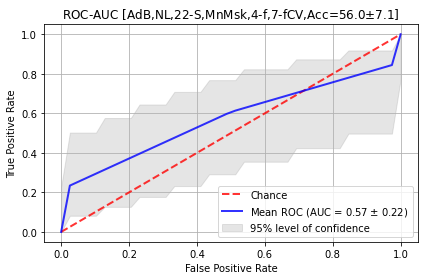

In [248]:
seed_value= 0
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)

fold_no = 7
acc_max = [] 

data_type  = np.float32
X_adb = np.zeros((fold_no, 45), dtype = data_type) 

acc_scores = []
folds = StratifiedKFold(n_splits=fold_no, shuffle=True, 
                        random_state=0).split(X, Y)

tprs = []
aucs = []
auc_est = []
# FPR becomes the independent ordinate
mean_fpr = np.linspace(0, 1, 40)
fig, ax = plt.subplots()

for j, (train_idx, test_idx) in enumerate(folds):

    X_train_CV = X.iloc[train_idx,:]  
    Y_train_CV = Y.iloc[train_idx]   
    X_test_CV = X.iloc[test_idx,:]   
    Y_test_CV = Y.iloc[test_idx]  

    model = None
    model = AdaBoostClassifier(n_estimators=100)
#     model = GradientBoostingClassifier(n_estimators=32)
    nb = model.fit(X_train_CV, Y_train_CV)

    predictions = model.predict(X_test_CV)     
    print(predictions)

    data_pred = model.predict(X_train_CV) 
    for n in range(len(data_pred)):
        X_adb[j,n] = data_pred[n]
    for q in range(len(predictions)):
        X_adb[j,n+q+1] = predictions[q]

    pred_label = []
    for i in predictions:
        if i<0.5:
            pred_label.append(0)
        else:
            pred_label.append(1)

    fpr, tpr, _ = roc_curve(Y_test_CV, pred_label)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

    acc = 0.   
    for i,j in zip(Y_test_CV,pred_label):      
        if i==j:
            acc+=1.

    acc/=(test_idx.size)  
    acc_scores.append(acc)
    
acc_scores_list = np.array(acc_scores)
test_statistic = lambda x: (np.mean(x), np.var(x))
estimate, bias, stderr, conf_interval = jackknife_stats(acc_scores_list, test_statistic, 0.95)    
print(estimate)    
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
# std_tpr = np.std(tprs, axis=0)

# Using Binomial conf intervals, as laid out in Sourati 2015
[tprs_upper, tprs_lower] = binom_conf_interval(mean_tpr*13, 13, confidence_level=0.95, interval='wilson')  

upper_lim = auc(mean_fpr, tprs_upper)
auc_est.append(upper_lim)
lower_lim = auc(mean_fpr, tprs_lower)
auc_est.append(lower_lim)
std_auc = abs(upper_lim-lower_lim)/2

ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'95% level of confidence')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
#        title="ROC-AUC [AdB,NL,22-Subs,1-feats,6-fold,Acc=%2.1f$\pm$%2.1f]" % (100*estimate[0],100*estimate[1]))
       title="ROC-AUC [AdB,NL,22-S,MnMsk,4-f,7-fCV,Acc=%2.1f$\pm$%2.1f]" % (100*estimate[0],100*estimate[1]))
#        title="ROC-AUC [AdB,Les,22-Subs,1-feats,6-fold,Acc=%2.1f$\pm$%2.1f]" % (100*estimate[0],100*estimate[1]))
#        title="ROC-AUC [AdB,Les,MnMsk,22-S,1-fts,7-fold,Acc=%2.1f$\pm$%2.1f]" % (100*estimate[0],100*estimate[1]))
ax.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid('True')    
plt.tight_layout() 
# plt.savefig('images//ROC-AUC [AdB,NL,22-S,1-fts,6-fCV]_Nov_25.png')     
plt.savefig('images//ROC-AUC [AdB,NL,MnMsk,22-S,4-fts,7-fCV]_Nov_25.png')     
# plt.savefig('images//ROC-AUC [AdB,Les,1-feats,22 Subs,6-fold CV]_Nov_26.png')     
# plt.savefig('images//ROC-AUC [AdB,Les,MnMsk,1-fts,22_S,7_fCV]_Nov_29_inf.png')   
#     plt.show()

In [160]:
# [AdB] Above & [Aggregate Results, Non Lesion, Aug 20] Below

In [ ]:
AdaBoost:
5- .62 0.6458333333333334
4- .64 [0.66964286 0.02930485]
3- [0.69387755 0.04392074] SVM
2- 0.629

RF:
5- [0.69047619 0.04761905]
4- .67 [0.6875     0.01782526]
3- [0.73511905 0.02632866] [0.69047619 0.05687831]

GBM:
5- [0.71428571 0.02739985]
4- [0.73129252 0.05039952]
3- [0.71428571 0.05517763]

XGBoost:
5- [0.67006803 0.02407947]
4- [0.67006803 0.02407947]
3- [0.69047619 0.01984127]
2- [0.67006803 0.01482021]

MLP (3 feats):
vanilla- [0.76530612 0.0473221] [0.62585034 0.00259151]
l2- [0.76190476 0.04232804] [0.71428571 0.02494331] [0.62585034 0.00259151]
l1- [0.6292517  0.01546809]

[0]	eval-auc:0.50000
Will train until eval-auc hasn't improved in 10 rounds.
[1]	eval-auc:0.41667
[0]	eval-auc:0.25000
Will train until eval-auc hasn't improved in 10 rounds.
[1]	eval-auc:0.33333
[0]	eval-auc:0.66667
Will train until eval-auc hasn't improved in 10 rounds.
[1]	eval-auc:0.75000
[0]	eval-auc:0.87500
Will train until eval-auc hasn't improved in 10 rounds.
[1]	eval-auc:0.75000
[0]	eval-auc:0.43750
Will train until eval-auc hasn't improved in 10 rounds.
[1]	eval-auc:0.56250
[0]	eval-auc:0.62500
Will train until eval-auc hasn't improved in 10 rounds.
[1]	eval-auc:0.50000
[0]	eval-auc:0.56250
Will train until eval-auc hasn't improved in 10 rounds.
[1]	eval-auc:0.68750
[0.69047619 0.01984127]
[0.6904761904761905]
0.6904761904761905
0


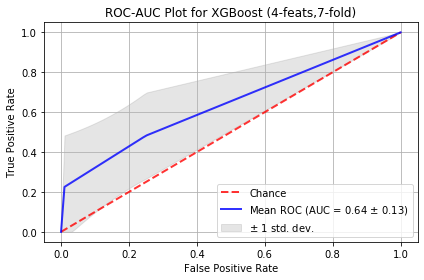

In [81]:
seed_value= 0
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)
   
fold_no = 6
acc_max = [] 
# m = [4, 5, 6, 8, 10, 12, 16, 20, 25, 32, 50, 64, 100] # No. of trees
# m = [10]

# for k in m:    

acc_scores = []
folds = StratifiedKFold(n_splits=fold_no, shuffle=True, 
                        random_state=0).split(X, Y)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
fig, ax = plt.subplots()

for j, (train_idx, test_idx) in enumerate(folds):

#     X_train_CV = X.iloc[train_idx,:]  
#     Y_train_CV = Y.iloc[train_idx]   
    X_test_CV = X.iloc[test_idx,:]   
    Y_test_CV = Y.iloc[test_idx]  
    train_list = list(train_idx)
    val_set = random.sample(train_list, 3)
    X_eval_CV = X.iloc[test_idx,:]   
    Y_eval_CV = Y.iloc[test_idx]  
    m = 0
    q = []
    for i in train_idx:
        if i not in val_set:            
            q.append(i)
            
    X_train_CV = X.iloc[q,:]  
    Y_train_CV = Y.iloc[q]   
    
#     X_train_CV[m] = X.iloc[i,:]  
#     Y_train_CV[m] = Y.iloc[i]   
            
#     print(val_set)
#     print(q)
#     print(test_idx)
    
    dtrain = xgb.DMatrix(X_train_CV, label=Y_train_CV)
    deval = xgb.DMatrix(X_eval_CV, label=Y_eval_CV)
    dtest = xgb.DMatrix(X_test_CV)
#     dtrain.save_binary('sim_files/train.buffer')
#     dtest.save_binary('sim_files/test.buffer')

    param = {'max_depth': 2, 'eta': 1, 'objective': 'binary:logistic'}
    param['nthread'] = 1
    param['eval_metric'] = 'auc'
    num_round = 2
#     evallist = [(deval, 'eval'), (dtrain, 'train')]
    evallist = [(deval, 'eval')]
    bst = None
    bst = xgb.train(param, dtrain, num_round, evals=evallist, early_stopping_rounds=10)
    
#     bst.save_model('0001.model')
    # dump model with feature map
#     bst.dump_model('dump.raw.txt', 'featmap.txt')

    predictions = bst.predict(dtest)        
    pred_label = []
    for i in predictions:
        if i<0.5:
            pred_label.append(0)
        else:
            pred_label.append(1)

    fpr, tpr, _ = roc_curve(Y_test_CV, pred_label)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

    acc = 0.   
    for i,j in zip(Y_test_CV,pred_label):      
        if i==j:
            acc+=1.

    acc/=(test_idx.size)  
    acc_scores.append(acc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="ROC-AUC Plot for XGBoost (4-feats,7-fold)")
ax.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid('True')    
plt.tight_layout()
plt.savefig('images//ROC-AUC [NL,45_Subs,7-fold,XGBoost]_Aug_27_.png')     
#     plt.show()

#     print(acc_scores)   
acc_scores_list = np.array(acc_scores)
#     resamples = jackknife_resampling(acc_scores_list)
test_statistic = lambda x: (np.mean(x), np.var(x))
estimate, bias, stderr, conf_interval = jackknife_stats(acc_scores_list, test_statistic, 0.95)    
print(estimate)
#     print(resamples)


acc_max.append(np.mean(acc_scores)) 
#     print(np.mean(acc_scores))
#     print(np.std(acc_scores))

print(acc_max)   
print(np.amax(acc_max))
print(np.argmax(acc_max))

In [160]:
# [XGBoost] Above & [RF] Below

[0.48       0.11011111]
[0.645      0.02969444]
[0.625      0.04069444]
[0.625      0.05847222]
[0.605      0.06358333]
[0.62       0.06566667]
[0.655      0.05413889]
[0.625   0.08125]
[0.67       0.06844444]
[0.695      0.05636111]
[0.67       0.04566667]
[0.715      0.03836111]
[0.69       0.02877778]
[0.4800000000000001, 0.6449999999999999, 0.625, 0.625, 0.605, 0.62, 0.655, 0.625, 0.67, 0.6950000000000001, 0.67, 0.7150000000000001, 0.6900000000000001]
0.7150000000000001
11


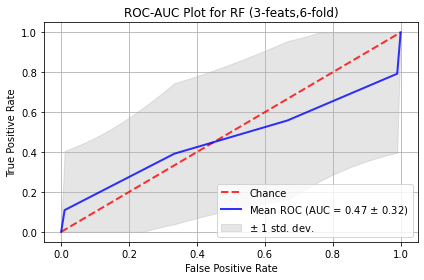

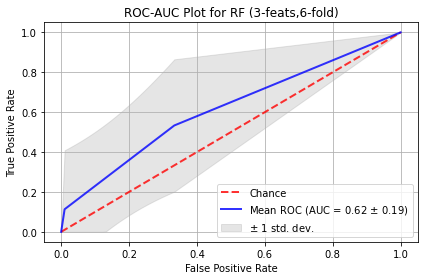

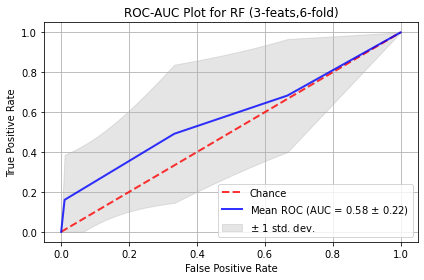

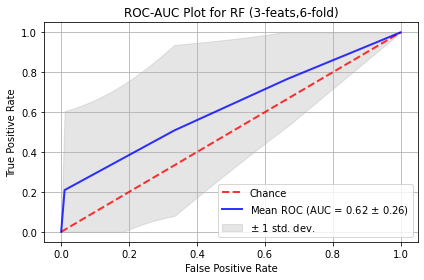

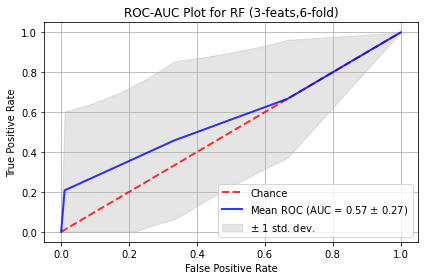

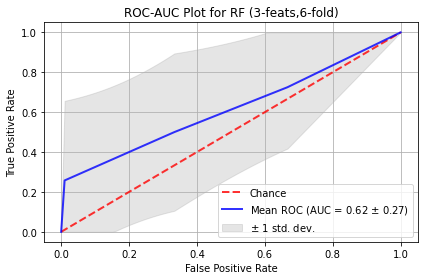

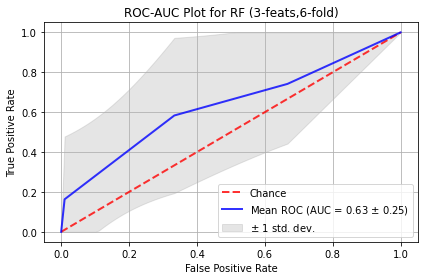

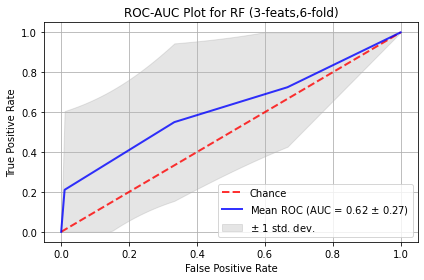

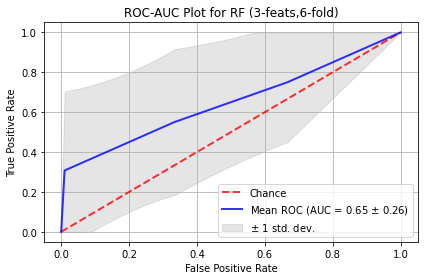

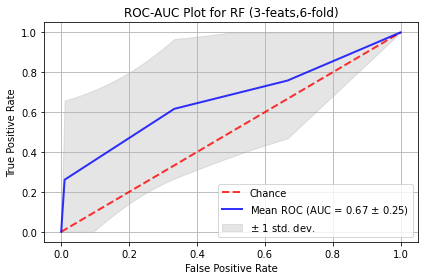

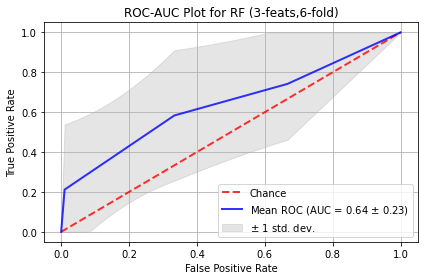

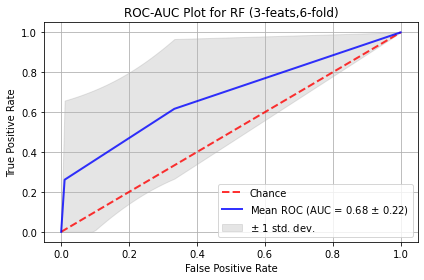

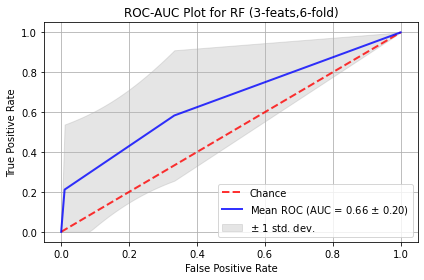

In [62]:
seed_value= 0
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)
   
fold_no = 10
acc_max = [] 
m = [4, 5, 6, 8, 10, 12, 16, 20, 25, 32, 50, 64, 75] # No. of trees

data_type  = np.float32
X_rf  = np.zeros((fold_no, 45), dtype = data_type) 

# fig, ax = plt.subplots()
for k in m:    
    acc_scores = []
    folds = StratifiedKFold(n_splits=fold_no, shuffle=True, 
                            random_state=0).split(X, Y)
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots()
    
    for j, (train_idx, test_idx) in enumerate(folds):

        X_train_CV = X.iloc[train_idx,:]  
        Y_train_CV = Y.iloc[train_idx]   
        X_test_CV = X.iloc[test_idx,:]   
        Y_test_CV = Y.iloc[test_idx]  

        model = None
        model = RandomForestRegressor(n_estimators=k)
        nb = model.fit(X_train_CV, Y_train_CV)

        predictions = model.predict(X_test_CV)      
        if k==64:
            data_pred = model.predict(X_train_CV) 
#             print(predictions)
            for n in range(len(data_pred)):
                X_rf[j,n] = data_pred[n]
            for q in range(len(predictions)):
                X_rf[j,n+q+1] = predictions[q]
#             print(n)
            
        pred_label = []
        for i in predictions:
            if i<0.5:
                pred_label.append(0)
            else:
                pred_label.append(1)                
             
#         if k>70:        
#             for n in range(len(pred_label)):
#                 X_rf[j,n] = pred_label[n]
#             for q in range(len(pred_label)):
#                 X_rf[j,n+q+1] = pred_label[q]
                
        fpr, tpr, _ = roc_curve(Y_test_CV, pred_label)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
                
        acc = 0.   
        for i,l in zip(Y_test_CV,pred_label):      
            if i==l:
                acc+=1.

        acc/=(test_idx.size)  
        acc_scores.append(acc)
    
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="ROC-AUC Plot for RF (3-feats,6-fold)")
    ax.legend(loc="lower right")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid('True')    
    plt.tight_layout()
#     plt.savefig('images//ROC-AUC-RF-2 [Without Lesion Norm, 45 Subs, 7-fold CV]_Aug_20.png')   
#     plt.show()

#     print(acc_scores)   
    acc_scores_list = np.array(acc_scores)
#     resamples = jackknife_resampling(acc_scores_list)
    test_statistic = lambda x: (np.mean(x), np.var(x))
    estimate, bias, stderr, conf_interval = jackknife_stats(acc_scores_list, test_statistic, 0.95)    
    print(estimate)
#     print(resamples)

    
    acc_max.append(np.mean(acc_scores)) 
#     print(np.mean(acc_scores))
#     print(np.std(acc_scores))

print(acc_max)   
print(np.amax(acc_max))
print(np.argmax(acc_max))

In [170]:
# Random Forest, 5 most separable features, 5 trees, 5 fold CV [Below]
[6 splits] 0.53809524 0.03964626

# Linear/RBF SVM, 5 most separable features, 5 fold CV [Below]
[Linear] [6 splits] [0.55  0.024]

# Random Forest, 4 most separable features, 5 trees, 5 fold CV [Below]
[6 splits] [0.57142857 0.01893878]

# Linear/RBF SVM, 4 most separable features, 5 fold CV [Below]
[Linear] [6 splits] [0.55  0.033]

# Random Forest, 3 most separable features, 100 trees, 5 fold CV [Below]
[6 splits] [0.5952381  0.02234014]

# Linear/RBF SVM, 3 most separable features, 5 fold CV [Below]
[Linear] [6 splits] [0.525   0.02475]

# Random Forest, 2 most separable features, 5 trees, 5 fold CV [Below]
[6 splits] [0.58571429 0.00840816]

# Linear/RBF SVM, 2 most separable features, 5 fold CV [Below]
[Linear] [6 splits] [0.525   0.02475]

# Random Forest, 1 most separable feature, 5 trees, 5 fold CV [Below]
[6 splits] 

# Linear/RBF SVM, 1 most separable feature, 5 fold CV [Below]
[Linear] [6 splits] 

In [182]:
# [Lesion Aggregate Results] Above & [Plot Data] Below

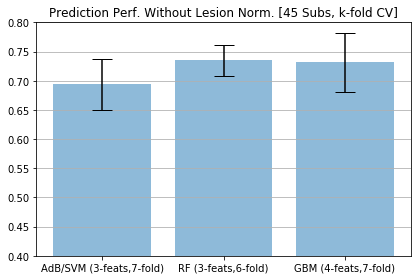

In [95]:
mu_RBF_2_3 = 0.69387755 
mu_RBF_4_5 = 0.73511905
mu_SVM_2_3_4_5 = 0.73129252

std_RBF_2_3 = 0.04392074
std_RBF_4_5 = 0.02632866
std_SVM_2_3_4_5 = 0.05039952

labels = ['AdB/SVM (3-feats,7-fold)', 'RF (3-feats,6-fold)', 'GBM (4-feats,7-fold)']
x_pos = np.arange(len(labels))

CTEs = [mu_RBF_2_3, mu_RBF_4_5,mu_SVM_2_3_4_5]
error = [std_RBF_2_3, std_RBF_4_5,std_SVM_2_3_4_5]

fig, ax = plt.subplots()
ax.bar(x_pos, CTEs,
       yerr=error,
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=10)
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_title('Prediction Perf. Without Lesion Norm. [45 Subs, k-fold CV]')
ax.yaxis.grid(True)
axes = plt.gca()
axes.set_ylim([0.4,0.8])

plt.tight_layout()
plt.savefig('images//Prediction Perf. Without Lesion Norm. [45 Subs, 7-fold CV]_Aug_20.png')
# ,ddof = 1

In [170]:
# Random Forest, 5 most separable features, 5 trees, 5 fold CV [Below]
[6 splits] 0.63333333 0.0040544

# Linear/RBF SVM, 5 most separable features, 5 fold CV [Below]
[Linear] [6 splits] [0.575   0.03075]

Adaboost = 0.56666667 0.05238095

# Random Forest, 4 most separable features, 5 trees, 5 fold CV [Below]
[6 splits] 0.62380952 0.05531973

# Linear/RBF SVM, 4 most separable features, 5 fold CV [Below]
[Linear] [6 splits] [0.575   0.03075]

Adaboost = 0.59047619 0.04789116

# Random Forest, 3 most separable features, 100 trees, 5 fold CV [Below]
[6 splits] [0.66666667 0.01621769]

# Linear/RBF SVM, 3 most separable features, 5 fold CV [Below]
[Linear] [6 splits] [0.6   0.036]

Adaboost = 0.66666667 0.0403809

# Random Forest, 2 most separable features, 5 trees, 5 fold CV [Below]
[6 splits] [0.69047619 0.01417687]

# Linear/RBF SVM, 2 most separable features, 5 fold CV [Below]
[Linear] [6 splits] [0.625   0.03075]

Adaboost = 0.72380952 0.01360544

In [182]:
# [Non-Lesion Aggregate Results] Above & [Plot Data] Below

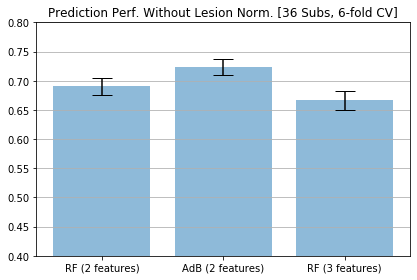

In [188]:
mu_RBF_2_3 = 0.69047619
mu_RBF_4_5 = 0.72380952
mu_SVM_2_3_4_5 = 0.66666667

std_RBF_2_3 = 0.01417687 
std_RBF_4_5 = 0.01360544 
std_SVM_2_3_4_5 = 0.01621769

labels = ['RF (2 features)', 'AdB (2 features)', 'RF (3 features)']
x_pos = np.arange(len(labels))

CTEs = [mu_RBF_2_3, mu_RBF_4_5,mu_SVM_2_3_4_5]
error = [std_RBF_2_3, std_RBF_4_5,std_SVM_2_3_4_5]

fig, ax = plt.subplots()
ax.bar(x_pos, CTEs,
       yerr=error,
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=10)
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_title('Prediction Perf. Without Lesion Norm. [36 Subs, 6-fold CV]')
ax.yaxis.grid(True)
axes = plt.gca()
axes.set_ylim([0.4,0.8])

plt.tight_layout()
plt.savefig('images//Prediction Perf. Without Lesion Norm. [36 Subs, 6-fold CV]_Aug_12.png')
# ,ddof = 1

[0 0 0 1 0]
[0 0 0 0 0]
[0 0 0 0 0]
[0 0 0 1 0]
[0 0 0 1 1]
[0 1 0 1]
[0 0 0 0]
[0 0 0 0]
[0 0 0 0]
[0 0 1 0]
[0.73  0.019]
[0.73]
0.73
0


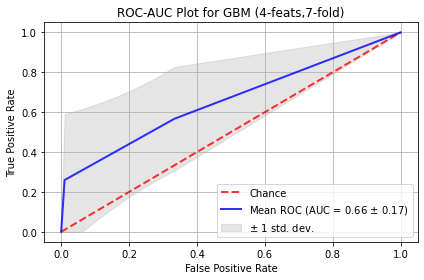

In [61]:
seed_value= 0
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)
   
fold_no = 10
acc_max = [] 
m = [4, 5, 6, 8, 10, 12, 16, 20, 25, 32, 50, 64, 75, 100] # No. of trees
m = [4]
# m = [25]

data_type  = np.float32
X_gbm = np.zeros((fold_no, 45), dtype = data_type) 

# fig, ax = plt.subplots()
for k in m:    
    acc_scores = []
    folds = StratifiedKFold(n_splits=fold_no, shuffle=True, 
                            random_state=0).split(X, Y)
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots()
    
    for j, (train_idx, test_idx) in enumerate(folds):

        X_train_CV = X.iloc[train_idx,:]  
        Y_train_CV = Y.iloc[train_idx]   
        X_test_CV = X.iloc[test_idx,:]   
        Y_test_CV = Y.iloc[test_idx]  

        model = None
        model = GradientBoostingClassifier(n_estimators=k)
        nb = model.fit(X_train_CV, Y_train_CV)

        predictions = model.predict(X_test_CV)        
        print(predictions)
        
        data_pred = model.predict(X_train_CV) 
        for n in range(len(data_pred)):
            X_gbm[j,n] = data_pred[n]
        for q in range(len(predictions)):
            X_gbm[j,n+q+1] = predictions[q]
                
        pred_label = []
        for i in predictions:
            if i<0.5:
                pred_label.append(0)
            else:
                pred_label.append(1)

        fpr, tpr, _ = roc_curve(Y_test_CV, pred_label)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
                
        acc = 0.   
        for i,j in zip(Y_test_CV,pred_label):      
            if i==j:
                acc+=1.

        acc/=(test_idx.size)  
        acc_scores.append(acc)
    
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="ROC-AUC Plot for GBM (4-feats,7-fold)")
    ax.legend(loc="lower right")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid('True')    
    plt.tight_layout()
    plt.savefig('images//ROC-AUC [Without Lesion Norm, 45 Subs, 7-fold CV]_Aug_20.png')     
#     plt.show()

#     print(acc_scores)   
    acc_scores_list = np.array(acc_scores)
#     resamples = jackknife_resampling(acc_scores_list)
    test_statistic = lambda x: (np.mean(x), np.var(x))
    estimate, bias, stderr, conf_interval = jackknife_stats(acc_scores_list, test_statistic, 0.95)    
    print(estimate)
#     print(resamples)

    
    acc_max.append(np.mean(acc_scores)) 
#     print(np.mean(acc_scores))
#     print(np.std(acc_scores))

print(acc_max)   
print(np.amax(acc_max))
print(np.argmax(acc_max))

In [75]:
#  [GBM] Above & [SVM] Below

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 

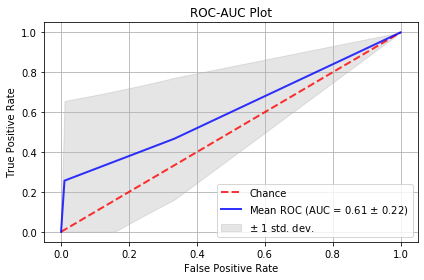

[0.695      0.03858333]


In [366]:
seed_value= 0
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)
   
fold_no = 10
acc_max = [] 

data_type  = np.float32
X_svm = np.zeros((fold_no, 45), dtype = data_type) 

acc_scores = []
folds = StratifiedKFold(n_splits=fold_no, shuffle=True, 
                        random_state=0).split(X, Y)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
fig, ax = plt.subplots()

for j, (train_idx, test_idx) in enumerate(folds):

    X_train_CV = X.iloc[train_idx,:]  
    Y_train_CV = Y.iloc[train_idx]   
    X_test_CV = X.iloc[test_idx,:]   
    Y_test_CV = Y.iloc[test_idx]  

    model = None
    model = svm.LinearSVC()
    nb = model.fit(X_train_CV, Y_train_CV)

    predictions = model.predict(X_test_CV)     
#     print(predictions)    
        
    data_pred = model.predict(X_train_CV) 
    for n in range(len(data_pred)):
        X_svm[j,n] = data_pred[n]
    for q in range(len(predictions)):
        X_svm[j,n+q+1] = predictions[q]
    
    print(X_svm)    
        
    pred_label = []
    for i in predictions:
        if i<0.5:
            pred_label.append(0)
        else:
            pred_label.append(1)

    fpr, tpr, _ = roc_curve(Y_test_CV, pred_label)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

    acc = 0.   
    for i,j in zip(Y_test_CV,pred_label):      
        if i==j:
            acc+=1.

    acc/=(test_idx.size)  
    acc_scores.append(acc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="ROC-AUC Plot")
ax.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid('True')    
plt.tight_layout()
#     plt.savefig('images//ROC-AUC [Without Lesion Norm, 36 Subs, 6-fold CV]_Aug_20.png')     
plt.show()

#     print(acc_scores)   
acc_scores_list = np.array(acc_scores)
#     resamples = jackknife_resampling(acc_scores_list)
test_statistic = lambda x: (np.mean(x), np.var(x))
estimate, bias, stderr, conf_interval = jackknife_stats(acc_scores_list, test_statistic, 0.95)    
print(estimate)
#     print(resamples)


# acc_max.append(np.mean(acc_scores)) 
# #     print(np.mean(acc_scores))
# #     print(np.std(acc_scores))

# print(acc_max)   
# print(np.amax(acc_max))
# print(np.argmax(acc_max)) 

/home/navid/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/navid/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/navid/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/navid/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

[0. 0.]


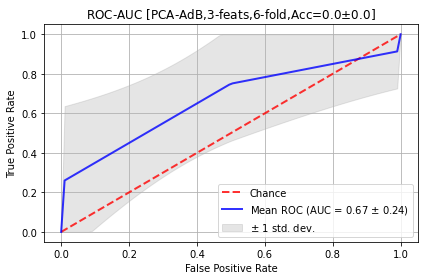

In [86]:
seed_value= 0
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)
from sklearn import decomposition
   
fold_no = 6
acc_max = [] 

data_type  = np.float32
X_pca_adb = np.zeros((fold_no, 45), dtype = data_type) 

acc_scores = []
folds = StratifiedKFold(n_splits=fold_no, shuffle=True, 
                        random_state=0).split(X, Y)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
fig, ax = plt.subplots()
PCA_axes = 2

pca = decomposition.PCA(n_components=PCA_axes)
pca.fit(X)
X_PCA = pca.transform(X)

for j, (train_idx, test_idx) in enumerate(folds):
 
    Y_train_CV = Y.iloc[train_idx]   
    Y_test_CV = Y.iloc[test_idx]        
#     Y_train_CV = Y[train_idx,:]   
#     Y_test_CV = Y[test_idx,:]          
    X_train_CV = X_PCA[train_idx,:] 
    X_test_CV = X_PCA[test_idx,:]   

    model = None
#     model = GaussianNB()
#     model = RandomForestRegressor(n_estimators=64)
#     model = GradientBoostingClassifier(n_estimators=4)
    model = AdaBoostClassifier(n_estimators=100)
    nb = model.fit(X_train_CV, Y_train_CV)

    predictions = model.predict(X_test_CV)     
#     print(predictions)

    data_pred = model.predict(X_train_CV) 
    for n in range(len(data_pred)):
        X_pca_adb[j,n] = data_pred[n]
    for q in range(len(predictions)):
        X_pca_adb[j,n+q+1] = predictions[q]

    pred_label = []
    for i in predictions:
        if i<0.5:
            pred_label.append(0)
        else:
            pred_label.append(1)

    fpr, tpr, _ = roc_curve(Y_test_CV, pred_label)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

    acc = 0.   
    for i,j in zip(Y_test_CV,pred_label):      
        if i==j:
            acc+=1.

    acc/=(test_idx.size)  
    acc_scores.append(acc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

acc_scores_list = np.array(acc_scores)
#     resamples = jackknife_resampling(acc_scores_list)
test_statistic = lambda x: (np.mean(x), np.var(x))
estimate, bias, stderr, conf_interval = jackknife_stats(acc_scores_list, test_statistic, 0.95)    
print(estimate)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="ROC-AUC [PCA-AdB,3-feats,6-fold,Acc=%2.1f$\pm$%2.1f]" % (100*estimate[0],100*estimate[1]))
#        title="ROC-AUC [PCA-AdB,3-feats,10-fold,Acc=%2.1f$\pm$%2.1f]" % (100*estimate[0],100*estimate[1]))
ax.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid('True')    
plt.tight_layout()
# plt.savefig('images//ROC-AUC [PCA-AdB, NL, 45 Subs, 10-fold CV]_Oct_22.png')     
plt.savefig('images//ROC-AUC [PCA-AdB, NL, 22 Subs, 6-fold CV]_Nov_25.png')     
#     plt.show()

# acc_max.append(np.mean(acc_scores)) 

In [ ]:
#  [PCA AdB] Above & [Fuse AdB] Below

[0.76       0.03544444]


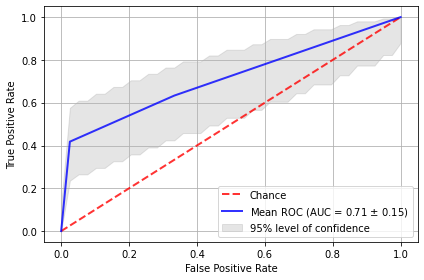

In [64]:
seed_value= 0
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)
   
fold_no = 10
acc_max = [] 
 
data_type  = np.float32
# X_mlr = np.zeros((fold_no,45,5), dtype = data_type) 
X_mlr = np.zeros((fold_no,45,4), dtype = data_type) 
X_mlr[:,:,0] = X_rf
X_mlr[:,:,1] = X_gbm
X_mlr[:,:,2] = X_adb
# X_mlr[:,:,3] = X_svm
X_mlr[:,:,3] = X_gnb
# X_mlr[:,:,4] = X_pca_adb
# print(X_mlr)

acc_scores = []
folds = StratifiedKFold(n_splits=fold_no, shuffle=True, 
                        random_state=0).split(X, Y)

tprs = []
aucs = []
auc_est = []
# FPR becomes the independent ordinate
mean_fpr = np.linspace(0, 1, 40)
fig, ax = plt.subplots()

for j, (train_idx, test_idx) in enumerate(folds):
    
#     print(train_idx)
    X_train_CV = X_mlr[j,0:len(train_idx),:]  
#     X_train_CV = 
#     X_train_CV = np.concatenate((X_train[:,0], X_train[:,1]), axis=0)
    Y_train_CV = Y.iloc[train_idx]   
    X_test_CV = X_mlr[j,len(train_idx):,:]   
#     X_test_CV = np.concatenate((X_test[:,0], X_test[:,1]), axis=None)
    Y_test_CV = Y.iloc[test_idx]  
    
#     print(X_test_CV)
#     print(Y_test_CV)
    model = None
#     model = linear_model.LinearRegression()
    model = linear_model.LogisticRegression(random_state=0)
#     model = GaussianNB()
#     model = AdaBoostClassifier(n_estimators=100)
    model.fit(X_train_CV, Y_train_CV)

#     coeff_df = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
#     print('\n',coeff_df)

    y_pred = model.predict(X_test_CV)
#     print(y_pred)
    
    pred_label = []
    for i in y_pred:
        if i<0.5:
            pred_label.append(0)
        else:
            pred_label.append(1)

#     print(pred_label)
    
    fpr, tpr, _ = roc_curve(Y_test_CV, pred_label)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
                
    acc = 0.   
    for i,j in zip(Y_test_CV,pred_label):      
        if i==j:
            acc+=1.

    acc/=(test_idx.size)  
    acc_scores.append(acc)

acc_scores_list = np.array(acc_scores)
#     resamples = jackknife_resampling(acc_scores_list)
test_statistic = lambda x: (np.mean(x), np.var(x))
estimate, bias, stderr, conf_interval = jackknife_stats(acc_scores_list, test_statistic, 0.95)    
print(estimate)    
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)


# tprs_list = np.array(tprs)
# tpr_est, bias, stderr, conf_interval = jackknife_stats(tprs_list, test_statistic, 0.95)    

mean_tpr = np.mean(tprs, axis=0)
# mean_tpr 
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

# Using Binomial conf intervals, as laid out in Sourati 2015
[tprs_upper, tprs_lower] = binom_conf_interval(mean_tpr*28, 28, confidence_level=0.95, interval='wilson')  

upper_lim = auc(mean_fpr, tprs_upper)
auc_est.append(upper_lim)
lower_lim = auc(mean_fpr, tprs_lower)
auc_est.append(lower_lim)

std_auc = abs(upper_lim-lower_lim)/2
# aucs = np.array(aucs)
# std_auc = aucs.std(axis=0)

ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)

# tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
# tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'95% level of confidence')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
#        title="ROC-AUC [Fusion,3-feats,10-fold,Acc=%2.1f$\pm$%2.1f]" % (100*estimate[0],100*estimate[1]))
ax.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid('True')    
plt.tight_layout()
plt.savefig('images//ROC-AUC[Fuse-AdB(PCA-AdB,RF,AdB,GBM,GNB), NL, 45 Subs, 10-fold CV, Acc]_Oct_29.png')    

In [57]:
# import pkg_resources
# pkg_resources.require("astropy==4.0.2")  # modified to use specific astropy
# test = binom_conf_interval(60, 100, interval='wilson')  
# [test1, test2]= binom_conf_interval(60, 100, confidence_level=0.95, interval='wilson')  
# print(test1)
# print(test2)
# print(astropy.__version__)
# print(mean_tpr)
# print(abs(upper_lim-lower_lim))
# print(tsne_results[:,0])
# rndperm = np.random.permutation(45)
# print(rndperm)
# print(df_subset)

# y_new = ','.join([str(x) for x in y_labels])
# print(y_new)

# a = [[1, 2],[3, 4],[5,6],[7,8],[9, 10],[11, 12],[13,14],[15,16]]
# a = np.asarray(a)
# # a = a.reshape((4,4))
# # a = a.reshape((2,2,4))
# a = a.reshape((4,2,2))
# print(a)
# # print(a.shape)

In [ ]:
#  [Expt Cells] Above & [t-SNE-3D] Below

[t-SNE] Computing 44 nearest neighbors...
[t-SNE] Indexed 45 samples in 0.000s...
[t-SNE] Computed neighbors for 45 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 45 / 45
[t-SNE] Mean sigma: 0.813825
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.321850
[t-SNE] KL divergence after 300 iterations: 2.048633
t-SNE done! Time elapsed: 0.2651515007019043 seconds


ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not ['No_Seizures' 'No_Seizures' 'No_Seizures' 'No_Seizures' 'No_Seizures'
 'No_Seizures' 'No_Seizures' 'No_Seizures' 'No_Seizures' 'No_Seizures'
 'No_Seizures' 'No_Seizures' 'No_Seizures' 'No_Seizures' 'No_Seizures'
 'No_Seizures' 'No_Seizures' 'No_Seizures' 'No_Seizures' 'No_Seizures'
 'No_Seizures' 'No_Seizures' 'No_Seizures' 'No_Seizures' 'No_Seizures'
 'No_Seizures' 'No_Seizures' 'No_Seizures' 'Late_Seizures' 'Late_Seizures'
 'Late_Seizures' 'Late_Seizures' 'Late_Seizures' 'Late_Seizures'
 'Late_Seizures' 'Late_Seizures' 'Late_Seizures' 'Late_Seizures'
 'Late_Seizures' 'Late_Seizures' 'Late_Seizures' 'Late_Seizures'
 'Late_Seizures' 'Late_Seizures' 'Late_Seizures']

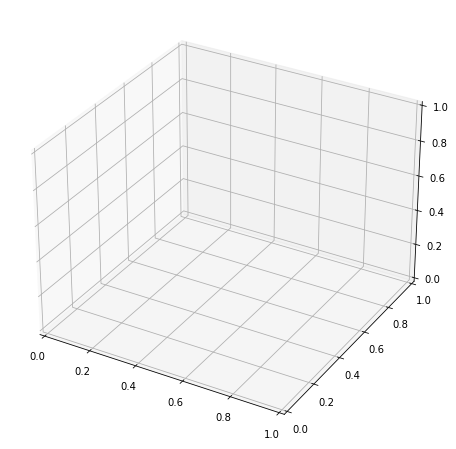

In [6]:
seed_value= 0
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)

df_subset = X.loc[:45,:].copy()

time_start = time.time()
tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)

tsne_results = tsne.fit_transform(X)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

df_subset['tsne-x'] = tsne_results[:,0]
df_subset['tsne-y'] = tsne_results[:,1]
df_subset['tsne-z'] = tsne_results[:,2]

ax = plt.figure(figsize=(8,8)).gca(projection='3d')
scatter = ax.scatter(
    xs=df_subset.loc[:45,:]["tsne-x"], 
    ys=df_subset.loc[:45,:]["tsne-y"], 
    zs=df_subset.loc[:45,:]["tsne-z"], 
    c=Y.loc[:45,:]["Label"], 
    cmap='flare')
# ,label=df_subset.loc[:45,:]["Label"])

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right")
#                     loc="upper right", title="Seizures")
ax.add_artist(legend1)
ax.set(title="t-SNE plot: [%2.0f features, %1.0f axes]" % (63,3))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

# plt.grid('True')    
plt.tight_layout()
plt.savefig('images//t-SNE-3D-All-Feats-Oct-22.png')     

[t-SNE] Computing 21 nearest neighbors...
[t-SNE] Indexed 22 samples in 0.000s...
[t-SNE] Computed neighbors for 22 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 22 / 22
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 44.699837
[t-SNE] KL divergence after 300 iterations: 0.476699


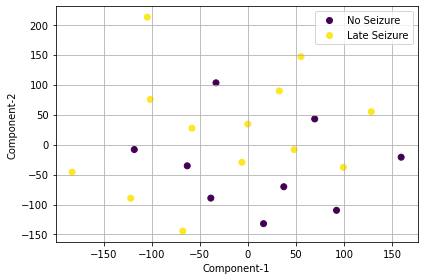

In [270]:
seed_value= 0
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)

# --- No. indicated #subs ---
k = 22
# df_subset = X.loc[:45,:].copy()
df_subset = None
df_subset = X.loc[:k,:].copy()
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)

tsne_results = tsne.fit_transform(X)
# print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

df_subset['tsne-x'] = tsne_results[:,0]
df_subset['tsne-y'] = tsne_results[:,1]

# plt.figure(figsize=(10,8))
# sns.scatterplot(
#     x="tsne-x", y="tsne-y",
#     hue="Label",
#     palette=sns.color_palette("viridis", 2),
# #     flare cubehelix
# #     palette=sns.color_palette("hls", 2),
#     data=df_subset,
#     legend="full",
#     alpha=0.3
# )
#     cmap='viridis')

fig, ax = plt.subplots()
# ax = plt.figure(figsize=(10,8))
cm = plt.cm.viridis
scat = ax.scatter(
#     x=df_subset.loc[:45,:]["tsne-x"], 
#     y=df_subset.loc[:45,:]["tsne-y"], 
#     c=Y.loc[:45,:]["Label"],
    x=df_subset.loc[:k,:]["tsne-x"], 
    y=df_subset.loc[:k,:]["tsne-y"], 
    c=Y.loc[:k,:]["Label"],
    cmap=cm)
# ,label=df_subset.loc[:45,:]["Label"])
legend_elem = [Line2D([0], [0], marker='o', color=cm(0.),lw=0,label='No Seizure'),
                   Line2D([0], [0], marker='o', color=cm(1.),lw=0,label='Late Seizure')]

# legend_elem = [Patch(facecolor=cm(0.), edgecolor='r',label='Color Patch'),
#                    Patch(facecolor=cm(1.), edgecolor='r',label=' Patch')]
# handles=

legend1 = ax.legend(handles=legend_elem,
                    loc="upper right")

# plt.legend(scat,
#            ['Low Outlier', 'LoLo'],
#            scatterpoints=1,
#            loc='lower left',
#            ncol=1,
#            fontsize=8)

# legend1 = ax.legend(*scatter.legend_elements(),
#                     loc="upper right")
# ax.add_artist(legend1)
# ax.set(title="t-SNE plot: [%2.0f features, %1.0f axes]" % (63,2))
ax.set_xlabel('Component-1')
ax.set_ylabel('Component-2')

# handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
# legend2 = ax.legend(handles, labels, loc="upper right", title="Sizes")
plt.grid('True')    
plt.tight_layout()
# plt.savefig('images//t-SNE-2D-All-Feats-Oct-28.png')
# plt.savefig('images//NL-22S-t-SNE-2D-All-Feats.png')     
# plt.savefig('images//NL-MnMsk-22S-t-SNE-2D-All-Feats.png')    
# plt.savefig('images//Les-MnMsk-22S-t-SNE-2D-All-Feats.png')    
plt.savefig('images//Les-22S-t-SNE-2D-All-Feats.png')     

In [75]:
#  [t-SNE-2D] Above & [PCA-2D-3D] Below

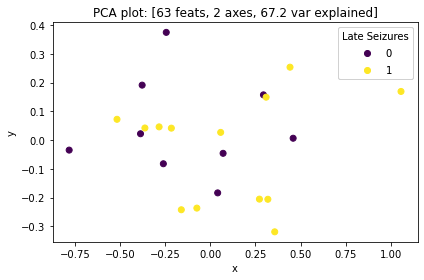

In [277]:
seed_value= 0
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)

# --- No. indicated #subs ---
k = 22

# df_subset = X.loc[:45,:].copy()
# pca = decomposition.PCA(n_components=3)
# pca.fit(X)
# exp_var = np.sum(pca.explained_variance_ratio_)
# pca_results = pca.transform(X)

# df_subset['pca-x'] = pca_results[:,0]
# df_subset['pca-y'] = pca_results[:,1]
# df_subset['pca-z'] = pca_results[:,2]

# ax = plt.figure(figsize=(8,8)).gca(projection='3d')
# scatter = ax.scatter(
#     xs=df_subset.loc[:45,:]["pca-x"], 
#     ys=df_subset.loc[:45,:]["pca-y"], 
#     zs=df_subset.loc[:45,:]["pca-z"], 
# #     c=Y.loc[:45], 
#     c=Y.loc[:45]["Label"], 
#     cmap='flare')
# # ,label=df_subset.loc[:45,:]["Label"])

# legend1 = ax.legend(*scatter.legend_elements(),
#                     loc="upper right", title="Late Seizures")
# ax.add_artist(legend1)
# ax.set(title="PCA plot: [%2.0f features, %1.0f axes, %2.1f var explained]" % (q,3,100*exp_var))
# ax.set_xlabel('x')
# ax.set_ylabel('y')
# ax.set_zlabel('z')

# # plt.grid('True')    
# plt.tight_layout()
# plt.savefig("images//PCA-3D-63-Feats-Oct-22.png")

# -----------------------------------------------------------------------------------------------------------------------

df_subset = df.loc[:k,:].copy()
pca = decomposition.PCA(n_components=2)
pca.fit(X)
exp_var = np.sum(pca.explained_variance_ratio_)
pca_results = pca.transform(X)

df_subset['pca-x-2'] = pca_results[:,0]
df_subset['pca-y-2'] = pca_results[:,1]

fig, ax = plt.subplots()
scatter = ax.scatter(
    x=df_subset.loc[:k,:]["pca-x-2"], 
    y=df_subset.loc[:k,:]["pca-y-2"], 
#     c=Y.loc[:45], 
    c=Y.loc[:k]["Label"], 
    cmap='viridis')

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Late Seizures")
ax.add_artist(legend1)
ax.set(title="PCA plot: [%d feats, %1.0f axes, %2.1f var explained]" % (q,2,100*exp_var))
ax.set_xlabel('x')
ax.set_ylabel('y')

# plt.grid('True')    
plt.tight_layout()
# plt.savefig('images//PCA-2D-63-Feats-Oct-22.png')     
# plt.savefig('images//NL-22S-PCA-2D-All-Feats.png')     
# plt.savefig('images//NL-MnMsk-22S-PCA-2D-All-Feats.png')    
# plt.savefig('images//Les-MnMsk-22S-PCA-2D-All-Feats.png')    
plt.savefig('images//Les-22S-PCA-2D-All-Feats.png')   

[0.72       0.04288889]


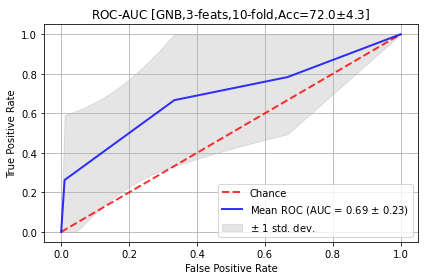

In [63]:
seed_value= 0
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)
from sklearn.naive_bayes import GaussianNB
   
fold_no = 10
acc_max = [] 

data_type  = np.float32
X_gnb = np.zeros((fold_no, 45), dtype = data_type) 

acc_scores = []
folds = StratifiedKFold(n_splits=fold_no, shuffle=True, 
                        random_state=0).split(X, Y)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
fig, ax = plt.subplots()

for j, (train_idx, test_idx) in enumerate(folds):

    X_train_CV = X.iloc[train_idx,:]  
    Y_train_CV = Y.iloc[train_idx]   
    X_test_CV = X.iloc[test_idx,:]   
    Y_test_CV = Y.iloc[test_idx]  

    model = None
    model = GaussianNB()
    nb = model.fit(X_train_CV, Y_train_CV)

    predictions = model.predict(X_test_CV)     
#     print(predictions)

    data_pred = model.predict(X_train_CV) 
    for n in range(len(data_pred)):
        X_gnb[j,n] = data_pred[n]
    for q in range(len(predictions)):
        X_gnb[j,n+q+1] = predictions[q]

    pred_label = []
    for i in predictions:
        if i<0.5:
            pred_label.append(0)
        else:
            pred_label.append(1)

    fpr, tpr, _ = roc_curve(Y_test_CV, pred_label)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

    acc = 0.   
    for i,j in zip(Y_test_CV,pred_label):      
        if i==j:
            acc+=1.

    acc/=(test_idx.size)  
    acc_scores.append(acc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

acc_scores_list = np.array(acc_scores)
#     resamples = jackknife_resampling(acc_scores_list)
test_statistic = lambda x: (np.mean(x), np.var(x))
estimate, bias, stderr, conf_interval = jackknife_stats(acc_scores_list, test_statistic, 0.95)    
print(estimate)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="ROC-AUC [GNB,3-feats,10-fold,Acc=%2.1f$\pm$%2.1f]" % (100*estimate[0],100*estimate[1]))
ax.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid('True')    
plt.tight_layout()
plt.savefig('images//ROC-AUC [GNB, NL, 45 Subs, 10-fold CV]_Sep_30.png')     
#     plt.show()

# acc_max.append(np.mean(acc_scores)) 

In [ ]:
# [GaussianNB] Above & [Stat Test P2] Below

In [256]:
# ALIC-L = 3
# ACR-L = 3
# CR = 3
# RLIC-R = 4
# FX/ST-L = 3

# mw_test = X mw_test.columns
mw_test = X[['ACR-L','ALIC-L','CR','FX/ST-L','RLIC-R']].copy()
# nl_std = mw_test.iloc[:,0]
# les_std = mw_test.iloc[:,1]
# nl_mnmsk = mw_test.iloc[:,2]
# les_mnmsk = mw_test.iloc[:,3]
f1_a = mw_test.iloc[0:9,0]      
f1_b = mw_test.iloc[9:22,0]      
f2_a = mw_test.iloc[0:9,1]
f2_b = mw_test.iloc[9:22,1]     
f3_a = mw_test.iloc[0:9,2]
f3_b = mw_test.iloc[9:22,2]      
f4_b = mw_test.iloc[9:22,3]      
f5_a = mw_test.iloc[0:9,4]
f5_b = mw_test.iloc[9:22,4]      

mwu_f1 = mannwhitneyu(f1_a, f1_b)
mwu_f2 = mannwhitneyu(f2_a, f2_b)
mwu_f3 = mannwhitneyu(f3_a, f3_b)
mwu_f4 = mannwhitneyu(f4_a, f4_b)
mwu_f5 = mannwhitneyu(f5_a, f5_b)

print(mwu_f1,str('\n'),mwu_f2,str('\n'),mwu_f3,str('\n'),mwu_f4,str('\n'),
      mwu_f5)
# MannwhitneyuResult(statistic=39.0, pvalue=0.10225922245215224) 
#  MannwhitneyuResult(statistic=44.0, pvalue=0.17492177693443117) 
#  MannwhitneyuResult(statistic=41.0, pvalue=0.12814011862216218) 
#  MannwhitneyuResult(statistic=33.0, pvalue=0.04751397636591205) 
#  MannwhitneyuResult(statistic=49.0, pvalue=0.2739191582698734)

MannwhitneyuResult(statistic=39.0, pvalue=0.10225922245215224) 
 MannwhitneyuResult(statistic=44.0, pvalue=0.17492177693443117) 
 MannwhitneyuResult(statistic=41.0, pvalue=0.12814011862216218) 
 MannwhitneyuResult(statistic=33.0, pvalue=0.04751397636591205) 
 MannwhitneyuResult(statistic=49.0, pvalue=0.2739191582698734)


In [290]:
mw_test = X[['ALIC-R','CGH-R','SS-R','UNC-R','EC-R','IFO-R','PTR-R','ALIC']].copy()
# nl_std = mw_test.iloc[:,0]
# les_std = mw_test.iloc[:,1]
# nl_mnmsk = mw_test.iloc[:,2]
# les_mnmsk = mw_test.iloc[:,3]
f1_a = mw_test.iloc[0:9,0]      
f1_b = mw_test.iloc[9:22,0]      # statistic=22.0, pvalue=0.00810816422375185
f2_a = mw_test.iloc[0:9,1]
f2_b = mw_test.iloc[9:22,1]      # statistic=40.0, pvalue=0.11468079274770782
f3_a = mw_test.iloc[0:9,2]
f3_b = mw_test.iloc[9:22,2]      # statistic=42.0, pvalue=0.142659034243989
f4_a = mw_test.iloc[0:9,3]
f4_b = mw_test.iloc[9:22,3]      # statistic=30.0, pvalue=0.030756799998021663
f5_a = mw_test.iloc[0:9,4]
f5_b = mw_test.iloc[9:22,4]      # statistic=34.0, pvalue=0.05450339490772108
f6_a = mw_test.iloc[0:9,5]
f6_b = mw_test.iloc[9:22,5]      # statistic=44.0, pvalue=0.17492177693443117

mwu_f1 = mannwhitneyu(f1_a, f1_b)
mwu_f2 = mannwhitneyu(f2_a, f2_b)
mwu_f3 = mannwhitneyu(f3_a, f3_b)
mwu_f4 = mannwhitneyu(f4_a, f4_b)
mwu_f5 = mannwhitneyu(f5_a, f5_b)
mwu_f6 = mannwhitneyu(f6_a, f6_b)

print(mwu_f1,str('\n'),mwu_f2,str('\n'),mwu_f3,str('\n'),mwu_f4,str('\n'),
      mwu_f5,str('\n'),mwu_f6)

MannwhitneyuResult(statistic=22.0, pvalue=0.00810816422375185) 
 MannwhitneyuResult(statistic=40.0, pvalue=0.11468079274770782) 
 MannwhitneyuResult(statistic=42.0, pvalue=0.142659034243989) 
 MannwhitneyuResult(statistic=30.0, pvalue=0.030756799998021663) 
 MannwhitneyuResult(statistic=34.0, pvalue=0.05450339490772108) 
 MannwhitneyuResult(statistic=44.0, pvalue=0.17492177693443117)


In [ ]:
# [Stat Test P3] Above & [Stat Test P4] Below

In [263]:
# ACR-R = 4
# ALIC-R = 6
# CGC-R = 1
# CGH-R = 2
# CST-L = 6
# EC-R = 5 
# IC-R = 6
# PLIC-R = 3
# PTR-R = 2
# UNC-R = 3

mw_test = X[['ACR-R','ALIC-R','CGC-R','CGH-R','CST-L','EC-R','IC-R','PLIC-R','PTR-R','UNC-R']].copy()
f1_a = mw_test.iloc[0:9,0]      
f1_b = mw_test.iloc[9:22,0]     
f2_a = mw_test.iloc[0:9,1]
f2_b = mw_test.iloc[9:22,1]     
f3_a = mw_test.iloc[0:9,2]
f3_b = mw_test.iloc[9:22,2]     
f4_a = mw_test.iloc[0:9,3]
f4_b = mw_test.iloc[9:22,3]     
f5_a = mw_test.iloc[0:9,4]
f5_b = mw_test.iloc[9:22,4]     
f6_a = mw_test.iloc[0:9,5]
f6_b = mw_test.iloc[9:22,5]     
f7_a = mw_test.iloc[0:9,6]
f7_b = mw_test.iloc[9:22,6]     
f8_a = mw_test.iloc[0:9,7]
f8_b = mw_test.iloc[9:22,7]    
f9_a = mw_test.iloc[0:9,8]
f9_b = mw_test.iloc[9:22,8]     
f10_a = mw_test.iloc[0:9,9]
f10_b = mw_test.iloc[9:22,9]     

mwu_f1 = mannwhitneyu(f1_a, f1_b)
mwu_f2 = mannwhitneyu(f2_a, f2_b)
mwu_f3 = mannwhitneyu(f3_a, f3_b)
mwu_f4 = mannwhitneyu(f4_a, f4_b)
mwu_f5 = mannwhitneyu(f5_a, f5_b)
mwu_f6 = mannwhitneyu(f6_a, f6_b)
mwu_f7 = mannwhitneyu(f7_a, f7_b)
mwu_f8 = mannwhitneyu(f8_a, f8_b)
mwu_f9 = mannwhitneyu(f9_a, f9_b)
mwu_f10 = mannwhitneyu(f10_a, f10_b)

print(mwu_f1,str('\n'),mwu_f2,str('\n'),mwu_f3,str('\n'),mwu_f4,str('\n'),
      mwu_f5,str('\n'),mwu_f6,str('\n'),mwu_f7,str('\n'),mwu_f8,str('\n'),mwu_f9,str('\n'),mwu_f10)

# MannwhitneyuResult(statistic=36.0, pvalue=0.07090049632185667) 
#  MannwhitneyuResult(statistic=22.0, pvalue=0.00810816422375185) 
#  MannwhitneyuResult(statistic=36.0, pvalue=0.07090049632185667) 
#  MannwhitneyuResult(statistic=41.0, pvalue=0.12814011862216218) 
#  MannwhitneyuResult(statistic=27.0, pvalue=0.019220566089161114) 
#  MannwhitneyuResult(statistic=34.0, pvalue=0.05450339490772108) 
#  MannwhitneyuResult(statistic=33.0, pvalue=0.04751397636591205) 
#  MannwhitneyuResult(statistic=30.0, pvalue=0.030756799998021663) 
#  MannwhitneyuResult(statistic=42.0, pvalue=0.142659034243989) 
#  MannwhitneyuResult(statistic=31.0, pvalue=0.035693516767219165)

MannwhitneyuResult(statistic=36.0, pvalue=0.07090049632185667) 
 MannwhitneyuResult(statistic=22.0, pvalue=0.00810816422375185) 
 MannwhitneyuResult(statistic=36.0, pvalue=0.07090049632185667) 
 MannwhitneyuResult(statistic=41.0, pvalue=0.12814011862216218) 
 MannwhitneyuResult(statistic=27.0, pvalue=0.019220566089161114) 
 MannwhitneyuResult(statistic=34.0, pvalue=0.05450339490772108) 
 MannwhitneyuResult(statistic=33.0, pvalue=0.04751397636591205) 
 MannwhitneyuResult(statistic=30.0, pvalue=0.030756799998021663) 
 MannwhitneyuResult(statistic=42.0, pvalue=0.142659034243989) 
 MannwhitneyuResult(statistic=31.0, pvalue=0.035693516767219165)


In [295]:
mw_test = X
i = 0
for col in mw_test.columns: 
    f1_a = mw_test.iloc[0:9,i]      
    f1_b = mw_test.iloc[9:22,i]     
    mwu_f1 = mannwhitneyu(f1_a, f1_b)
    print(col,mwu_f1)
    i += 1

# print(mwu_f1,str('\n'),mwu_f2,str('\n'),mwu_f3,str('\n'),mwu_f4,str('\n'),
#       mwu_f5,str('\n'),mwu_f6,str('\n'),mwu_f7,str('\n'),mwu_f8,str('\n'),mwu_f9,str('\n'),mwu_f10)

ACR MannwhitneyuResult(statistic=37.0, pvalue=0.08040699248961625)
ACR-L MannwhitneyuResult(statistic=39.0, pvalue=0.10225922245215224)
ACR-R MannwhitneyuResult(statistic=34.0, pvalue=0.05450339490772108)
ALIC MannwhitneyuResult(statistic=37.0, pvalue=0.08040699248961625)
ALIC-L MannwhitneyuResult(statistic=44.0, pvalue=0.17492177693443117)
ALIC-R MannwhitneyuResult(statistic=36.0, pvalue=0.07090049632185667)
AverageFA MannwhitneyuResult(statistic=45.0, pvalue=0.1926657633947762)
BCC MannwhitneyuResult(statistic=56.0, pvalue=0.4468767951021961)
CC MannwhitneyuResult(statistic=51.0, pvalue=0.32009026805025587)
CGC MannwhitneyuResult(statistic=46.0, pvalue=0.21146838192952833)
CGC-L MannwhitneyuResult(statistic=53.0, pvalue=0.36923117674929123)
CGC-R MannwhitneyuResult(statistic=49.0, pvalue=0.2739191582698734)
CGH MannwhitneyuResult(statistic=53.0, pvalue=0.36923117674929123)
CGH-L MannwhitneyuResult(statistic=45.0, pvalue=0.1926657633947762)
CGH-R MannwhitneyuResult(statistic=46.0, pva

In [ ]:
# [Stat Test P1] Above & [Exp Cells] Below

In [291]:
# stats.ttest_ind(f1_a, f1_b, alternative='less')
t1 = stats.ttest_ind(f1_a, f1_b, equal_var = False)
t4 = stats.ttest_ind(f4_a, f4_b, equal_var = False)
t5 = stats.ttest_ind(f5_a, f5_b, equal_var = False)
# t8 = stats.ttest_ind(f8_a, f8_b, equal_var = False)

# Ttest_indResult(statistic=2.6856330389525613, pvalue=0.014229554739582833) 
#  Ttest_indResult(statistic=1.7920228391360984, pvalue=0.0890809844171399) 
#  Ttest_indResult(statistic=1.918883747876253, pvalue=0.0745960275346535) 
#  Ttest_indResult(statistic=2.2140147904042164, pvalue=0.04015503960973033)

print(t1,str('\n'),t4,str('\n'),t5,str('\n'),t8)

# mw_test = X[['ALIC-R']].copy()
# # nl_std = mw_test.iloc[:,0]
# # les_std = mw_test.iloc[:,1]
# # nl_mnmsk = mw_test.iloc[:,2]
# # les_mnmsk = mw_test.iloc[:,3]
# f1_a = mw_test.iloc[0:9,0]      
# f1_b = mw_test.iloc[9:22,0]      # statistic=22.0, pvalue=0.00810816422375185

# mwu_f1 = mannwhitneyu(f1_a, f1_b)

# print(mwu_f1)

Ttest_indResult(statistic=2.6856330389525613, pvalue=0.014229554739582833) 
 Ttest_indResult(statistic=1.7920228391360984, pvalue=0.0890809844171399) 
 Ttest_indResult(statistic=1.918883747876253, pvalue=0.0745960275346535) 
 Ttest_indResult(statistic=1.6994419277070454, pvalue=0.1047480826373884)


In [38]:
def CNN(main_input,dr_rate=0,filters=(2,4,8), ker_size=(2,2), init='glorot_uniform', bn=True, bias=True,
        act='relu',act_f='sigmoid',l_1=0,l_2=0,a_1=0,a_2=0,mu=0,std=1,layer_no=2,dr=False):
    
    y = Conv2D(filters=filters[0], kernel_regularizer=l1_l2(l1=l_1, l2=l_2), use_bias=bias, 
               activity_regularizer=l1_l2(l1=a_1, l2=a_2), kernel_size=ker_size, 
               padding='same', activation=act, kernel_initializer=init, name='conv_1')(main_input)
    if bn:
        y = BatchNormalization(name='bn_up_1')(y)
    if dr:
        y = Dropout(name='dropout_1',rate=dr_rate)(y)
    y  = MaxPooling2D(padding='same', name='pool_1')(y)
    
    if layer_no>1:   
        y = Conv2D(filters=filters[1], kernel_regularizer=l1_l2(l1=l_1, l2=l_2), use_bias=bias,
                   activity_regularizer=l1_l2(l1=a_1, l2=a_2), kernel_size=ker_size,
                   padding='same', activation=act, kernel_initializer=init, name='conv_2')(y)
        if bn:
            y = BatchNormalization(name='bn_up_2')(y)
        if dr:
            y = Dropout(name='dropout_2',rate=dr_rate)(y)
        y  = MaxPooling2D(padding='same', name='pool_2')(y)   

    if layer_no>2:        
        y = Conv2D(filters=filters[2], kernel_regularizer=l1_l2(l1=l_1, l2=l_2), use_bias=bias,
                   activity_regularizer=l1_l2(l1=a_1, l2=a_2), kernel_size=ker_size,
                   padding='same', activation=act, kernel_initializer=init, name='conv_3')(y)
        if bn:
            y = BatchNormalization(name='bn_up_3')(y)
        if dr:
            y = Dropout(name='dropout_3',rate=dr_rate)(y)
        y  = MaxPooling2D(padding='same', name='pool_3')(y)    
    
    y = Flatten()(y)    
    y = Dense(1,activation=act_f)(y)
    
    return y

In [ ]:
# [CNN func] Above & [CNN Train+Eval] Below

In [36]:
seed_value= 0
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)

# all_preds = []
subj = 22
feats_list = [6] # no. of features selected
fold_list = [6]
# cv_rep = [1,2,3,4,5]
cv_rep = [16]

data_type  = np.float32
acc_max = []
auc_max = []

for feats in cv_rep:
    for fold_no in fold_list:

        acc_scores = []        
        folds = StratifiedKFold(n_splits=fold_no, shuffle=True, 
                                    random_state=0).split(X, Y)
#                                     random_state=feats).split(X, Y)

        for k, (train_idx, test_idx) in enumerate(folds):

            X_train_CV = X[train_idx,:]  
            Y_train_CV = Y[train_idx]   
#             Y_train_CV = np.ravel(Y_train_CV)
            X_test_CV = X[test_idx,:]   
            Y_test_CV = Y[test_idx]  
#             Y_test_CV = np.ravel(Y_test_CV)          
            
#             sel_mutual = SelectKBest(chi2, k=feats)    
            sel_mutual = SelectKBest(mutual_info_classif, k=feats)
#             sel_mutual = SelectKBest(f_classif, k=feats)
            X_train_CV = sel_mutual.fit_transform(X_train_CV, Y_train_CV)
            X_test_CV = sel_mutual.transform(X_test_CV)            
            
            X_train_CV = X_train_CV.reshape((len(train_idx),4,4,1))
            X_test_CV = X_test_CV.reshape((len(test_idx),4,4,1))
        
            run_str = str(feats)+'_feats_CNN_fold_'+str(k+1)
#             run_str = 'CNN_fold_'+str(k+1)

            seizure_label = None
#             img = Input(shape=(8,8,1))
            img = Input(shape=(4,4,1))
#             seizure_label = CNN(main_input=img, bn=True, 
#                                 l_1=1e-2,layer_no=2,dr=True,dr_rate=0.1,act_f=relu_out)
            seizure_label = CNN(main_input=img, bn=True, l_1=1e-1,l_2=1e-1,layer_no=2)
            
            Conv_FA = None
            Conv_FA = Model(img, seizure_label) 

            Conv_FA.compile(optimizer='Adam', loss=losses.binary_crossentropy, metrics=['accuracy'])
#             Conv_FA.compile(optimizer='Adam'Adadelta(lr=1.0), loss=losses.mean_squared_error, metrics=['mse'])
            Conv_FA.summary()
            es = EarlyStopping(monitor='loss', mode='auto', verbose=1, patience=10, min_delta=5e-5) 
            lred = ReduceLROnPlateau(monitor='loss', factor=0.7, min_delta = 1e-4,
                                     mode='auto', patience=5, verbose=1, min_lr=1e-5, cooldown=0)
            mc = ModelCheckpoint('weights//'+run_str+'.h5', monitor='loss', mode='auto',
                                 save_best_only=True, verbose=1)

            history = Conv_FA.fit(X_train_CV, Y_train_CV, callbacks=[es,lred,mc], epochs=50)

            Conv_FA.load_weights('weights//'+run_str+'.h5', by_name=True)
            predictions = Conv_FA.predict(X_test_CV)
#             all_preds.append(predictions)

            pred_label = []
            for i in predictions:
                if i<0.5:
                    pred_label.append(0)
                else:
                    pred_label.append(1)

            acc = 0.   
            for i,j in zip(Y_test_CV,pred_label):      
                if i==j:
                    acc+=1.

            acc /= (test_idx.size)  
            acc_scores.append(acc)
            print('\n The accuracy for fold-'+str(k+1)+' is: '+ str(acc))

        print(np.mean(acc_scores))
        print(np.std(acc_scores))

#         acc_scores_list = []
#         acc_scores_list = np.array(acc_scores)
#         #     resamples = jackknife_resampling(acc_scores_list)
#         test_statistic = lambda x: (np.mean(x), np.var(x))
#         estimate, bias, stderr, conf_interval = jackknife_stats(acc_scores_list, test_statistic, 0.95)    
#         print(estimate)
#         print(acc_scores_list)

/home/navid/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Model: "model_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_63 (InputLayer)        [(None, 4, 4, 1)]         0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 4, 4, 4)           20        
_________________________________________________________________
bn_up_1 (BatchNormalization) (None, 4, 4, 4)           16        
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 2, 2, 4)           0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 2, 2, 8)           136       
_________________________________________________________________
bn_up_2 (BatchNormalization) (None, 2, 2, 8)           32        
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 1, 1, 8)           0  

/home/navid/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Model: "model_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_64 (InputLayer)        [(None, 4, 4, 1)]         0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 4, 4, 4)           20        
_________________________________________________________________
bn_up_1 (BatchNormalization) (None, 4, 4, 4)           16        
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 2, 2, 4)           0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 2, 2, 8)           136       
_________________________________________________________________
bn_up_2 (BatchNormalization) (None, 2, 2, 8)           32        
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 1, 1, 8)           0  

/home/navid/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Model: "model_63"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_65 (InputLayer)        [(None, 4, 4, 1)]         0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 4, 4, 4)           20        
_________________________________________________________________
bn_up_1 (BatchNormalization) (None, 4, 4, 4)           16        
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 2, 2, 4)           0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 2, 2, 8)           136       
_________________________________________________________________
bn_up_2 (BatchNormalization) (None, 2, 2, 8)           32        
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 1, 1, 8)           0  

/home/navid/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Model: "model_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_66 (InputLayer)        [(None, 4, 4, 1)]         0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 4, 4, 4)           20        
_________________________________________________________________
bn_up_1 (BatchNormalization) (None, 4, 4, 4)           16        
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 2, 2, 4)           0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 2, 2, 8)           136       
_________________________________________________________________
bn_up_2 (BatchNormalization) (None, 2, 2, 8)           32        
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 1, 1, 8)           0  

/home/navid/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Model: "model_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_67 (InputLayer)        [(None, 4, 4, 1)]         0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 4, 4, 4)           20        
_________________________________________________________________
bn_up_1 (BatchNormalization) (None, 4, 4, 4)           16        
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 2, 2, 4)           0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 2, 2, 8)           136       
_________________________________________________________________
bn_up_2 (BatchNormalization) (None, 2, 2, 8)           32        
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 1, 1, 8)           0  

Feat: 63
Accuracy: 0.48611111111111116
SEM (Acc): 0.11168854585730878
Sensitivity: 0.5
Specificity: 0.4444444444444444
AUC: 0.4739754547446855
Runtime: 0.7749403120251372


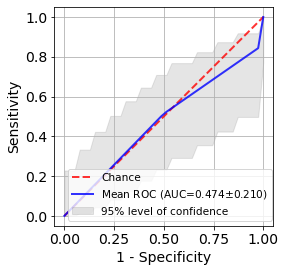

In [458]:
seed_value= 0
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)

subj = 22
# feats_list = [1,2,3,4,5] # no. of features selected
# feats_list = [1,2,3,4,5,6,7,8,9,10] # no. of features selected
fold_no = 6
rs = 0 
data_type  = np.float32
feats_list = [63] # no. of features selected
t1 = time.perf_counter()

for feats in feats_list:          
      
    acc_scores = []
    f1_scores = []
    sensitivity1 = []
    specificity1 = []    
    tprs = []
    aucs = []
    auc_est = [] # FPR becomes the independent ordinate    
    mean_fpr = np.linspace(0, 1, 40)
    fig, ax = plt.subplots()
    
    folds = StratifiedKFold(n_splits=fold_no, shuffle=True, 
                            random_state=rs).split(X, Y)
    for k, (train_idx, test_idx) in enumerate(folds):
        X_train_CV = X.iloc[train_idx,:]  
        Y_train_CV = Y.iloc[train_idx]   
        Y_train_CV = np.ravel(Y_train_CV)
        X_test_CV = X.iloc[test_idx,:]   
        Y_test_CV = Y.iloc[test_idx]  
        Y_test_CV = np.ravel(Y_test_CV)

#             ##--- Univariate feature selection ---##
#         sel_mutual = SelectKBest(mutual_info_classif, k=feats)
#         sel_mutual = SelectKBest(chi2, k=feats)
#         sel_mutual = SelectKBest(f_classif, k=feats)

#         X_train_CV = sel_mutual.fit_transform(X_train_CV, Y_train_CV)
#         X_test_CV = sel_mutual.transform(X_test_CV)
        
#         if feats == 10:
#             features_dataframe = X
#             mask = sel_mutual.get_support()
#             new_features = features_dataframe.columns[mask]
#             display(new_features)
    
#         model = LinearDiscriminantAnalysis()          
        model = AdaBoostClassifier(n_estimators=100)         

        nb = model.fit(X_train_CV, Y_train_CV)                      
        pred_label = model.predict(X_test_CV) 
                
        cm1 = confusion_matrix(Y_test_CV,pred_label)
        total1 = sum(sum(cm1))

        sensitivity1.append(cm1[0,0]/(cm1[0,0]+cm1[0,1]))        
        specificity1.append(cm1[1,1]/(cm1[1,0]+cm1[1,1]))

        fpr, tpr, _ = roc_curve(Y_test_CV, pred_label)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        acc = 0.   
        for i,j in zip(Y_test_CV,pred_label):      
            if i==j: 
                acc+=1.

        acc/=(test_idx.size)  
        acc_scores.append(acc)
        
#         f1_scores.append(f1_score(Y_test_CV, pred_label, average='weighted'))

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    # std_tpr = np.std(tprs, axis=0)

    # Using Binomial conf intervals, as laid out in Sourati 2015
    [tprs_upper, tprs_lower] = binom_conf_interval(mean_tpr*13, 13, confidence_level=0.95, interval='wilson')  

    upper_lim = auc(mean_fpr, tprs_upper)
    lower_lim = auc(mean_fpr, tprs_lower)
    std_auc = abs(upper_lim-lower_lim)/2

    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC=%0.3f$\pm$%0.3f)' % (mean_auc, std_auc),
#             label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'95% level of confidence')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
#                title="Q-LDA,Les,22-S,%d-f,%d-CV,Acc=%2.1f$\pm$%2.1f]" % (feats,fold_no,100*estimate[0],100*estimate[1]))

#     ax.legend(loc="lower right")
    ax.legend(loc="lower right", bbox_to_anchor=(1.02,0))
    plt.xlabel('1 - Specificity')
    plt.ylabel('Sensitivity')
    plt.grid('True')    
    plt.gca().set_aspect("equal")
#     plt.rcParams.update({'font.size': 11})
#     val = 12
#     matplotlib.rc('xtick', labelsize=val) 
#     matplotlib.rc('ytick', labelsize=val) 
    SMALL_SIZE = 8
    MEDIUM_SIZE = 10
    BIGGER_SIZE = 14

    plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=10.5)    # legend fontsize
    plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title
    plt.tight_layout()   
#     plt.savefig('images/best_of/choose/pp1-vf.png')  
             
    print('Feat:', feats)
    print('Accuracy:', np.mean(acc_scores))
    print('SEM (Acc):', 1.96*stats.sem(acc_scores,ddof=0))
    print('Sensitivity:', np.mean(sensitivity1))
#     print(1.96*stats.sem(sensitivity1,ddof=0))
    print('Specificity:', np.mean(specificity1))
#     print(1.96*stats.sem(specificity1,ddof=0))
    print('AUC:', mean_auc)
#     print(std_auc)
    print('Runtime:', time.perf_counter()-t1)
            
# print('Accuracy_Max at: %d' %np.argmax(acc_max))
# print('AUC_Max at: %d' %np.argmax(auc_max))       
# print(np.mean(auc_max))

In [40]:
# Pipeline-2
# Index(['CR', 'RLIC-R', 'UNC', 'UNC-R'], dtype='object')
# Index(['ACR-L', 'CR', 'RLIC-R', 'SS-R'], dtype='object')
# Index(['ALIC-L', 'PTR', 'PTR-L', 'SS-R'], dtype='object')
# Index(['ACR-L', 'FX/ST-L', 'RLIC-R', 'SFO'], dtype='object')
# Index(['ACR-L', 'ALIC-L', 'CR', 'FX/ST-L'], dtype='object')
# Index(['ALIC-L', 'CST-R', 'FX/ST-L', 'RLIC-R'], dtype='object')
# ALIC-L = 3
# ACR-L = 3
# CR = 3
# RLIC-R = 4
# FX/ST-L = 3

# Pipeline-3
# Index(['ALIC', 'ALIC-R', 'CGH-R', 'PTR-R', 'SS-R', 'UNC-R'], dtype='object')
# Index(['ACR-R', 'ALIC-R', 'CGC-R', 'IFO-R', 'SS-R', 'UNC-R'], dtype='object')
# Index(['ALIC', 'ALIC-R', 'CST-L', 'EC-R', 'SCC', 'UNC-R'], dtype='object')
# Index(['ACR-R', 'ALIC', 'ALIC-R', 'CGH-R', 'EC-R', 'PTR-R'], dtype='object')
# Index(['ALIC-R', 'CGH-R', 'EC-R', 'FX/ST-R', 'IFO-R', 'SS-R'], dtype='object')
# Index(['ALIC-R', 'CGH-R', 'IFO-R', 'SCC', 'SS-R', 'UNC-R'], dtype='object')
# ALIC-R = 6
# CGH-R = 4
# SS-R = 4
# UNC-R = 4
# EC-R = 3 
# IFO-R = 3 

# Pipeline-4
# Index(['ALIC', 'ALIC-R', 'CST', 'CST-L', 'EC', 'EC-R', 'IC', 'IC-R', 'PLIC-R', 'UNC-R'], dtype='object')
# Index(['ACR', 'ACR-R', 'ALIC', 'ALIC-R', 'CGC-R', 'CR-R', 'CST-L', 'EC-R','IC-R', 'UNC-R'],dtype='object')
# Index(['ALIC', 'ALIC-R', 'CST-L', 'IC-R', 'PCR-R', 'PLIC-R', 'PTR-R', 'SCR-R','UNC', 'UNC-R'],dtype='object')
# Index(['ACR', 'ACR-R', 'ALIC', 'ALIC-R', 'CGH-R', 'CST-L', 'EC', 'EC-R','IC-R', 'PTR-R'],dtype='object')
# Index(['ACR-R', 'ALIC', 'ALIC-R', 'CGH', 'CGH-R', 'CST', 'CST-L', 'EC', 'EC-R','IC-R'],dtype='object')
# Index(['ACR-R', 'ALIC', 'ALIC-R', 'CST', 'CST-L', 'CST-R', 'EC', 'EC-R','IC-R', 'PLIC-R'],dtype='object')
# ALIC-R = 6
# ACR-R = 4
# CST-L = 6
# EC-R = 5 
# IC-R = 6
# UNC-R = 3
# CGH-R = 2
# PLIC-R = 3
# PTR-R = 2
# CGC-R = 1



# display(mw_test)

# axarr = mw_test.boxplot(column='Count', by='Condition',
#                         figsize=(8, 6), grid=False)
# axarr.set_title('')
# axarr.set_ylabel('Number of Depressive Episodes')

# For 6 folds
# 0.7666995397764629
# 0.7666666666666666

# For 5 folds
# 0.7043447293447295
# 0.725

# Lesion
# [0.75, 0.75, 0.75, 1.0, 0.6666666666666666, 1.0]
# 0.8194444444444443
# 0.1310275157230084
# 0.7852290159982468

# Non-lesion
# [0.5, 0.75, 0.75, 0.75, 1.0, 0.6666666666666666]
# 0.7361111111111112
# 0.14764091406575902
# 0.7175651983344291

    #     Y_train_CV = Y_train_CV[:,np.newaxis]
    
#     auc_est.append(upper_lim)
#     auc_est.append(lower_lim)
#     auc_max.append(mean_auc)
    
# #         sel_mutual.ranking_
# #         print(sel_mutual.get_support())
# #         print(sel_mutual.get_params())

#     acc_scores_list = np.array(acc_scores)
#     test_statistic = lambda x: (np.mean(x), np.var(x))
#     estimate, bias, stderr, conf_interval = jackknife_stats(acc_scores_list, test_statistic, 0.95)    
# #     print(estimate)    
#     ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
#     acc_max.append(estimate[0])

In [ ]:
# [Eg Classifier] Above & [Example ROC-AUC source codes] Below

In [2]:
def plot_roc_curve(estimator, X, y, *, sample_weight=None,
                   drop_intermediate=True, response_method="auto",
                   name=None, ax=None, **kwargs):

    from sklearn.base import is_classifier
    from sklearn.utils import check_matplotlib_support
    from sklearn.base import _check_classifer_response_method
    
    check_matplotlib_support('plot_roc_curve')
    classification_error = ("{} should be a binary classifier".format(estimator.__class__.__name__))
    if not is_classifier(estimator):
        raise ValueError(classification_error)

    prediction_method = _check_classifer_response_method(estimator,
                                                         response_method)
    y_pred = prediction_method(X)

    if y_pred.ndim != 1:
        if y_pred.shape[1] != 2:
            raise ValueError(classification_error)
        else:
            y_pred = y_pred[:, 1]

    pos_label = estimator.classes_[1]
    fpr, tpr, _ = roc_curve(y, y_pred, pos_label=pos_label,
                            sample_weight=sample_weight,
                            drop_intermediate=drop_intermediate)
    roc_auc = auc(fpr, tpr)
    name = estimator.__class__.__name__ if name is None else name
    viz = RocCurveDisplay(
        fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=name
    )
    return viz.plot(ax=ax, name=name, **kwargs)

In [ ]:

#         y_probas = class_labels.fit_transform(predictions)
#         y_labels = nb.predict(X_test_CV)
#         y_labels = [Y_test_CV]
#         y_labels = class_labels.fit_transform(Y_test_CV.astype(str))
#         y_labels = ','.join([str(x) for x in y_labels])


#     df_pred = pd.DataFrame({'Actual': Y_test, 'Predicted': y_pred})
#     print('\n',df_pred.head(10))

#         print('Y_test_CV'+str(Y_test_CV)+'\n')
#         print('predictions'+str(predictions)+'\n')

#         coeff_df = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
#         print(coeff_df)

#         y_pred = model.predict(X_test_CV)

#         df_pred = pd.DataFrame({'Actual': Y_test_CV, 'Predicted': y_pred})
#         # print(df.head(10))
#     #     print('\n'+str(X.shape[0]))
#         mse = mean_squared_error(Y_test_CV, y_pred)
#         norm = np.mean(Y_test_CV**2)
#         nrmse = np.sqrt(mse/norm)                  
#         print("\n NRMSE Value: ", nrmse)
#         loss_nrmse_6m.append(nrmse) 

#         vaf = np.mean((Y_test_CV - np.mean(Y_test_CV))**2)
#         NMSE = mse/vaf          
#         print("\n NMSE (for comparison): ", NMSE)
#         loss_NMSE_6m.append(NMSE) 

#         count = 0
#         for i in range(Y_test_CV.size):
#             if np.sign(Y_test_CV.iloc[i])>0 and np.sign(y_pred[i])>0:
#                 count += 1
#             elif np.sign(Y_test_CV.iloc[i])<=0 and np.sign(y_pred[i])<=0:
#                 count += 1

#         score = 100*count/(Y_test_CV.size)
#         print('\n Accuracy: ',score,'%')

data_type  = np.float32
X_mlr = np.zeros((6, 45,2), dtype = data_type) 
X_mlr[:,:,0] = X_rf
X_mlr[:,:,1] = X_gbm
print(X_mlr[0,0:5,:])
print(np.concatenate((X_mlr[0,0:5,0], X_mlr[0,0:5,1]), axis=None))
print(X_mlr)

In [ ]:
# Experimental cells above & below

In [26]:

# [ 2  7 12 16]
# [ 1  6 10 20]
# [ 3  8 19 21]
# [ 5  9 17 18]
# [ 0 14 15]
# [ 4 11 13]

# cv_rep = [2,9,16,27,52] # for 5 folds
# cv_rep = [0,13,27,30,68] # for 6 folds
# cv_rep = [0,13,27,30,49,57,62,68] # for 6 folds
# cv_rep = [91,92,93,94,95,96,89,98,99,100]

# select_feats.div(feats)    
# select_feats_sorted = select_feats.sort_values(by='Scores', ascending=False)
# print('\n',select_feats_sorted.head(10))

seed_value= 0
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)

subj = 22
feats_list = [6] # no. of features selected
fold_list = [5]
cv_rep = [1,2,3,4,5]

data_type  = np.float32

for feats in cv_rep:
    for fold_no in fold_list:
        
        for k, (train_idx, test_idx) in enumerate(folds):
            folds = StratifiedKFold(n_splits=fold_no, shuffle=True, 
                                    random_state=feats).split(X, Y)

            print(test_idx) 
                           
#             print(model_tree.feature_importances_)
#             selected_features_df = pd.DataFrame({'Feature':list(X_train_CV.columns), 'Scores':sel_mutual_feat.scores_})
#             select_feats_sorted = selected_features_df.sort_values(by='Scores', ascending=False)
#             print('\n',select_feats_sorted.head(10))
#             if k==0:
#                 select_feats = selected_features_df
#             else:
#                 select_feats.add(selected_features_df)

#             sel_mutual = RFE(estimator=model_tree, n_features_to_select=feats, step=1)

# print(Y_train_CV.shape)
# Y_train_CV = np.ravel(Y_train_CV)
# print(X_train_rfe_tree.shape)
# X_test_new = sel_rfe_tree.transform(X_test_CV)
# print(X_test_new.shape)

# sel_rfe_tree.ranking_
# print(sel_mutual.get_support())
# print(sel_mutual.get_params())

[ 5  6 20 21]
[ 1  4 13 16]
[ 2  8 11 14]
[ 3  9 12 18]
[ 7 15 19]
[ 0 10 17]
[ 4  5 15 19 21]
[ 1  7 10 11 14]
[ 6  8 17 18]
[ 2  3  9 13]
[ 0 12 16 20]
[ 1  5 10 20 21]
[ 3  4 15 18 19]
[ 0  6 11 12]
[ 2  7 14 17]
[ 8  9 13 16]
[ 5  7 10 11 14]
[ 1  6 13 17 21]
[ 3  4 15 16]
[ 0  2 12 19]
[ 8  9 18 20]
[ 5  6 10 12 15]
[ 0  3  9 11 16]
[ 1  7 13 20]
[ 2  8 14 17]
[ 4 18 19 21]


Model: "model_567"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 3)]               0         
_________________________________________________________________
fc_1 (Dense)                 (None, 5)                 20        
_________________________________________________________________
fc_4 (Dense)                 (None, 1)                 6         
Total params: 26
Trainable params: 26
Non-trainable params: 0
_________________________________________________________________
Train on 40 samples
Epoch 1/80
32/40 [=======================>......] - ETA: 0s - loss: 0.6203 - accuracy: 0.3438
Epoch 00001: loss improved from inf to 0.61421, saving model to weights//3feats_fuse_1L_w5_1.h5
40/40 [==============================] - 0s 8ms/sample - loss: 0.6142 - accuracy: 0.3750
Epoch 2/80
32/40 [=======================>......] - ETA: 0s - loss: 0.6063 - accuracy: 0.437

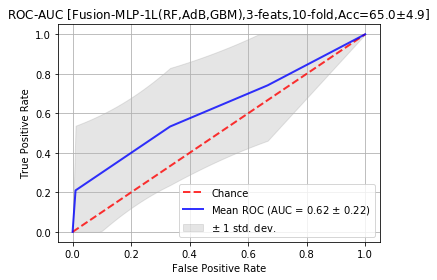

In [395]:
seed_value= 0
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)
   
fold_no = 10
acc_max = [] 
 
data_type  = np.float32
X_mlr = np.zeros((fold_no,45,3), dtype = data_type) 
# X_mlr = np.zeros((fold_no,45,4), dtype = data_type) 
X_mlr[:,:,0] = X_rf
X_mlr[:,:,1] = X_gbm
X_mlr[:,:,2] = X_adb
# X_mlr[:,:,3] = X_svm
# print(X_mlr)

acc_scores = []
folds = StratifiedKFold(n_splits=fold_no, shuffle=True, 
                        random_state=0).split(X, Y)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
fig, ax = plt.subplots()

for j, (train_idx, test_idx) in enumerate(folds):
    
#     print(train_idx)
    X_train_CV = X_mlr[j,0:len(train_idx),:]  
    Y_train_CV = Y.iloc[train_idx]   
    X_test_CV = X_mlr[j,len(train_idx):,:]   
    Y_test_CV = Y.iloc[test_idx]  
    
    X_train_CV = np.array(X_train_CV)
    Y_train_CV = np.array(Y_train_CV)
    X_test_CV = np.array(X_test_CV)
    Y_test_CV = np.array(Y_test_CV)       
    
    run_str = '3feats_fuse_1L_w5_'+str(j+1) 

    PGM = None
    PGM = pgm(net='dom', l_2=1e-4)

#     PGM.compile(optimizer=Adadelta(lr=1.0), loss='mean_squared_error', metrics=['mse'])
    PGM.compile(optimizer=Adadelta(lr=1.0), loss=losses.binary_crossentropy, metrics=['accuracy'])
    
    PGM.summary()
    es = EarlyStopping(monitor='loss', mode='auto', verbose=1, patience=10, min_delta=5e-5) 
    lred = ReduceLROnPlateau(monitor='loss', factor=0.7, min_delta = 1e-4,
                             mode='auto', patience=5, verbose=1, min_lr=1e-5, cooldown=0)
    mc = ModelCheckpoint('weights//'+run_str+'.h5', monitor='loss', mode='auto',
                         save_best_only=True, verbose=1)

    history = PGM.fit(X_train_CV, Y_train_CV, callbacks=[es,lred,mc], epochs=80)
    
    PGM.load_weights('weights//'+run_str+'.h5', by_name=True)
    y_pred = PGM.predict(X_test_CV)
    
#     print(y_pred)
    
    pred_label = []
    for i in y_pred:
        if i<0.5:
            pred_label.append(0)
        else:
            pred_label.append(1)

#     print(pred_label)
    
    fpr, tpr, _ = roc_curve(Y_test_CV, pred_label)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
                
    acc = 0.   
    for i,j in zip(Y_test_CV,pred_label):      
        if i==j:
            acc+=1.

    acc/=(test_idx.size)  
    acc_scores.append(acc)

acc_scores_list = np.array(acc_scores)
#     resamples = jackknife_resampling(acc_scores_list)
test_statistic = lambda x: (np.mean(x), np.var(x))
estimate, bias, stderr, conf_interval = jackknife_stats(acc_scores_list, test_statistic, 0.95)    
print(estimate)    
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)


# tprs_list = np.array(tprs)
# tpr_est, bias, stderr, conf_interval = jackknife_stats(tprs_list, test_statistic, 0.95)    

mean_tpr = np.mean(tprs, axis=0)
# mean_tpr 
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

std_auc = np.std(aucs)
# aucs = np.array(aucs)
# std_auc = aucs.std(axis=0)

ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="ROC-AUC [Fusion-MLP-1L(RF,AdB,GBM),3-feats,10-fold,Acc=%2.1f$\pm$%2.1f]" % (100*estimate[0],100*estimate[1]))
#        title="ROC-AUC Plot [Fusion(RF,AdB,GBM,SVM), 3-feats, 10-fold]")
ax.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid('True')    
plt.tight_layout()
plt.savefig('images//ROC-AUC [Fusion-MLP_1L(RF,AdB,GBM), NL, 45 Subs, 10-fold CV, Acc]_Sep_24.png')    
# plt.savefig('images//ROC-AUC [Fusion(RF,AdB,GBM,SVM), NL, 45 Subs, 10-fold CV]_Sep_17.png')     
#     plt.show()

#     print(acc_scores)   


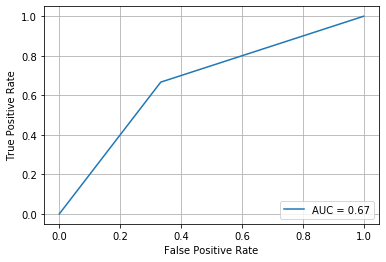

In [12]:
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, random_state=0)
clf = svm.SVC(random_state=0)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

fpr, tpr, _ = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)
viz = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
viz.plot()

# plot_roc_curve(clf, X_test, y_test)  # doctest: +SKIP
plt.grid(True)
plt.show()   

[0 0 0 0 0]
[1 0 1 0 0]
[0 0 0 1 0]
[0 1 1 1 0]
[1 0 0 1 0]
[0 0 0 0]
[0 0 0 0]
[0 0 0 0]
[1 0 0 0]
[0 0 0 0]
[0.56       0.04711111]
[0 0 0 1 0]
[1 0 1 0 0]
[1 0 0 1 0]
[1 1 1 1 0]
[0 0 0 0 0]
[0 1 0 1]
[0 0 0 1]
[0 0 0 0]
[1 0 0 0]
[0 0 0 0]
[0.565      0.07613889]
[0 0 0 1 0]
[1 0 1 0 0]
[1 1 0 1 0]
[0 1 1 1 0]
[1 0 0 0 0]
[0 1 0 1]
[0 0 0 1]
[0 0 0 0]
[1 0 0 0]
[0 0 0 0]
[0.545      0.06969444]
[0 1 1 1 0]
[1 0 1 0 0]
[1 1 0 1 0]
[1 1 1 1 0]
[0 0 0 0 0]
[0 1 0 1]
[1 0 0 1]
[0 0 0 0]
[1 0 0 0]
[0 0 0 0]
[0.48       0.05066667]
[0 1 1 1 0]
[1 0 1 0 0]
[0 1 0 1 0]
[1 1 1 0 0]
[0 0 0 1 0]
[0 1 0 1]
[1 0 0 1]
[0 0 0 0]
[1 0 0 0]
[0 0 0 0]
[0.5        0.07777778]
[0 1 0 1 0]
[1 0 0 0 0]
[0 1 0 1 0]
[1 1 1 0 0]
[0 0 0 1 0]
[0 1 0 1]
[1 0 0 1]
[1 0 0 0]
[1 0 0 0]
[0 0 0 0]
[0.515      0.06169444]
[0 0 1 1 0]
[1 0 1 0 0]
[0 1 0 1 0]
[1 1 1 0 0]
[0 0 0 1 0]
[0 1 0 0]
[1 0 0 1]
[1 0 0 0]
[1 0 0 0]
[0 0 0 0]
[0.47       0.06288889]
[0 1 0 1 0]
[1 0 1 0 0]
[0 1 0 1 0]
[1 1 1 0 0]
[0 0 0 0 0]
[0

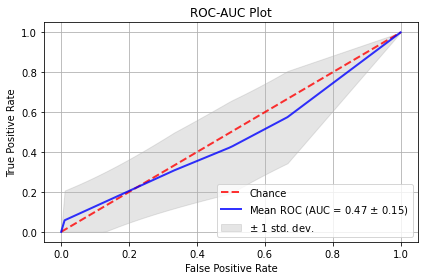

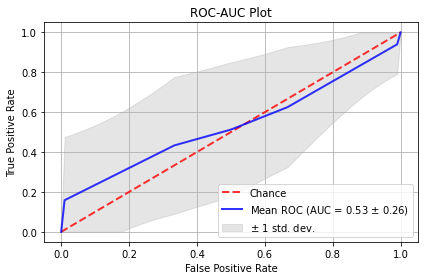

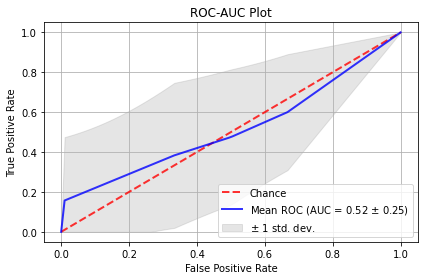

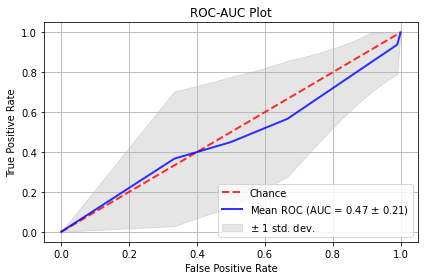

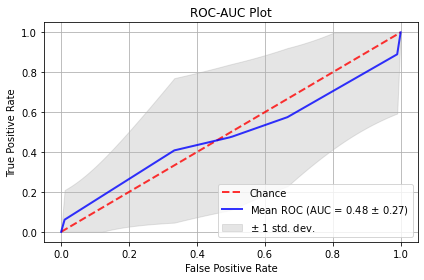

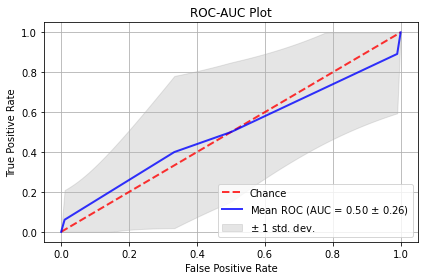

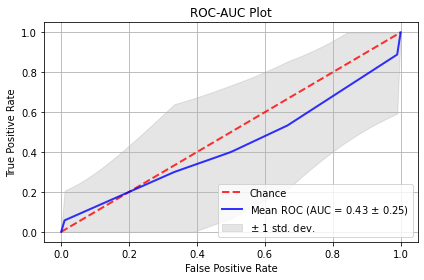

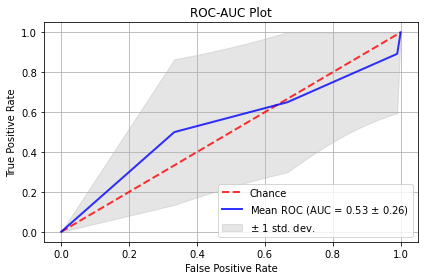

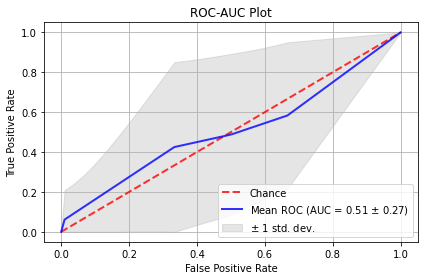

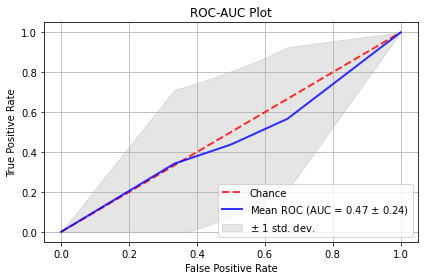

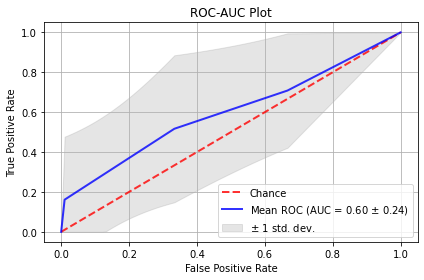

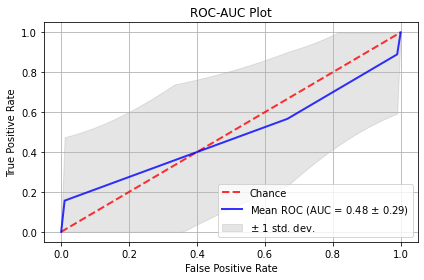

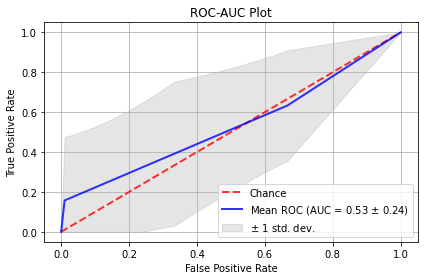

In [57]:
seed_value= 0
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)
   
fold_no = 10
acc_max = [] 
m = [4, 5, 6, 8, 10, 12, 16, 20, 25, 32, 50, 64, 100] # No. of trees

data_type  = np.float32
X_adb = np.zeros((fold_no, 45), dtype = data_type) 

# fig, ax = plt.subplots()
for k in m:    
    acc_scores = []
    folds = StratifiedKFold(n_splits=fold_no, shuffle=True, 
                            random_state=0).split(tsne_results, Y)
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots()
    
    for j, (train_idx, test_idx) in enumerate(folds):

        X_train_CV = tsne_results[train_idx,:]  
        Y_train_CV = Y.iloc[train_idx]   
        X_test_CV = tsne_results[test_idx,:]   
        Y_test_CV = Y.iloc[test_idx]  

        model = None
        model = AdaBoostClassifier(n_estimators=k)
        nb = model.fit(X_train_CV, Y_train_CV)

        predictions = model.predict(X_test_CV)     
        print(predictions)
        
        data_pred = model.predict(X_train_CV) 
        for n in range(len(data_pred)):
            X_adb[j,n] = data_pred[n]
        for q in range(len(predictions)):
            X_adb[j,n+q+1] = predictions[q]
            
        pred_label = []
        for i in predictions:
            if i<0.5:
                pred_label.append(0)
            else:
                pred_label.append(1)

        fpr, tpr, _ = roc_curve(Y_test_CV, pred_label)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
                
        acc = 0.   
        for i,j in zip(Y_test_CV,pred_label):      
            if i==j:
                acc+=1.

        acc/=(test_idx.size)  
        acc_scores.append(acc)
    
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="ROC-AUC Plot")
    ax.legend(loc="lower right")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid('True')    
    plt.tight_layout()
#     plt.savefig('images//ROC-AUC [AdB-tSNE-Oct15.png')     
#     plt.show()

#     print(acc_scores)   
    acc_scores_list = np.array(acc_scores)
#     resamples = jackknife_resampling(acc_scores_list)
    test_statistic = lambda x: (np.mean(x), np.var(x))
    estimate, bias, stderr, conf_interval = jackknife_stats(acc_scores_list, test_statistic, 0.95)    
    print(estimate)